# Imports

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 19)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize': (16, 9)})

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Obtenir les données

In [2]:
spotify_data = pd.read_csv("data/spotify-extr.txt", sep=" ")

# Description de l'ensemble du jeu de données

In [3]:
spotify_data.head()

valence  year  acousticness  danceability  duration  energy  \
161704    0.647  1975        0.4490         0.376    298840   0.827   
168077    0.150  2008        0.8990         0.508    236800   0.169   
35922     0.423  2007        0.0185         0.470    301093   0.878   
135823    0.302  1995        0.0384         0.176    142200   0.980   
165395    0.828  1994        0.5310         0.705    187800   0.625   

        instrumentalness key  liveness  loudness  mode  popularity  \
161704          0.007880   B     0.466    -7.604     1          25   
168077          0.000011  Ab     0.136   -11.332     1          42   
35922           0.083900   B     0.276    -5.576     0          65   
135823          0.552000   B     0.237    -3.154     1          36   
165395          0.000008   G     0.348   -11.963     0          38   

        speechiness    tempo pop.class  
161704       0.3990  170.475         C  
168077       0.0553  107.477         B  
35922        0.0377  150.093         A  
135823       0.0721  172.566         C  
165395       0.0639   97.831         C

In [4]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 161704 to 90217
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           10000 non-null  float64
 1   year              10000 non-null  int64  
 2   acousticness      10000 non-null  float64
 3   danceability      10000 non-null  float64
 4   duration          10000 non-null  int64  
 5   energy            10000 non-null  float64
 6   instrumentalness  10000 non-null  float64
 7   key               10000 non-null  object 
 8   liveness          10000 non-null  float64
 9   loudness          10000 non-null  float64
 10  mode              10000 non-null  int64  
 11  popularity        10000 non-null  int64  
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  float64
 14  pop.class         10000 non-null  object 
dtypes: float64(9), int64(4), object(2)
memory usage: 1.2+ MB


Les variables sont :
* `valence` : la positivité de la chanson, vaut 1 si la chanson est très joyeuse, 0 sinon ;
* `year` : année de sortie ;
* `acousticness` : mesure "l'acousticité" de la chanson ;
* `danceability` : mesure la "dançabilite" d'une chanson ;
* `duration` : durée d'une chanson en millisecondes ;
* `energy` : l'énergie de la chanson, vaut 1 si la chanson est très énergétique, 0 sinon ;
* `intrumentalness` : taux d'instrumentalisation, vaut 1 s'il n'y a aucune voix présente dans la chanson, 0 sinon ; 
* `key` : tonalité de la musique (ex : A=la), ne prend pas en compte la distinction majeur/mineur ;
* `liveness` : taux de prestation en live, vaut 1 si la chanson ne comporte que de la musique (sans sons à intérêts non-musicaux), 0 sinon ;
* `loudness` : intensité sonore de la chanson
* `mode` : variable binaire qui indique si la chanson commence par une progression d'accords majeure (1) ou non (0)
* `speechiness` : taux de vocaux dans la chanson, vaut 1 si la chanson comporte de la voix tout le long, 0 sinon ;
* `tempo` :  tempo de la chanson en beats par minute (bpm)

Notre objectif consiste à prédire la valeur de `pop.class`, la popularité d'une chanson.

In [5]:
spotify_data.describe()

valence          year  acousticness  danceability      duration  \
count  10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean       0.532815   1977.026200      0.495719      0.540029  2.272151e+05   
std        0.262431     26.000068      0.377681      0.176193  1.124568e+05   
min        0.000000   1921.000000      0.000000      0.000000  5.991000e+03   
25%        0.324000   1956.000000      0.092675      0.417000  1.690670e+05   
50%        0.543000   1978.000000      0.504000      0.550000  2.065295e+05   
75%        0.751000   1999.000000      0.889250      0.671000  2.597330e+05   
max        0.993000   2020.000000      0.996000      0.988000  2.703227e+06   

             energy  instrumentalness      liveness      loudness  \
count  10000.000000      10000.000000  10000.000000  10000.000000   
mean       0.487500          0.164947      0.204063    -11.437683   
std        0.267729          0.313327      0.173221      5.787993   
min        0.000000          0.000000      0.000000    -60.000000   
25%        0.262000          0.000000      0.097800    -14.557000   
50%        0.476000          0.000174      0.135000    -10.552500   
75%        0.708000          0.087100      0.256000     -7.115500   
max        1.000000          1.000000      0.991000      1.342000   

              mode    popularity   speechiness         tempo  
count  10000.00000  10000.000000  10000.000000  10000.000000  
mean       0.71470     31.558100      0.101815    116.865750  
std        0.45158     21.915904      0.168111     30.969039  
min        0.00000      0.000000      0.000000      0.000000  
25%        0.00000     11.000000      0.035000     93.564500  
50%        1.00000     33.000000      0.045400    114.437500  
75%        1.00000     48.250000      0.078600    135.470000  
max        1.00000     93.000000      0.969000    214.419000

In [6]:
data_qual = spotify_data[["pop.class", "mode", "key"]]
data_qual.head()

pop.class  mode key
161704         C     1   B
168077         B     1  Ab
35922          A     0   B
135823         C     1   B
165395         C     0   G

On transforme les variables qualitatives en catégories pour mieux traiter les données.

In [7]:
spotify_data["key"] = pd.Categorical(spotify_data["key"], ordered=False)
spotify_data["mode"] = pd.Categorical(spotify_data["mode"], ordered=False)
spotify_data["pop.class"] = pd.Categorical(spotify_data["pop.class"],
                                           ordered=True)

In [8]:
spotify_data.dtypes

valence              float64
year                   int64
acousticness         float64
danceability         float64
duration               int64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
popularity             int64
speechiness          float64
tempo                float64
pop.class           category
dtype: object

# Analyses uni et multidimensionnelles

Voici les boxplots de toutes les variables quantitatives.

In [9]:
data_quant = spotify_data[spotify_data.columns.difference(
    ['key', 'mode', 'pop.class'], sort=False)]
data_quant.keys()

Index(['valence', 'year', 'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness',
       'tempo'],
      dtype='object')

Saving figure quantitative_data_histograms


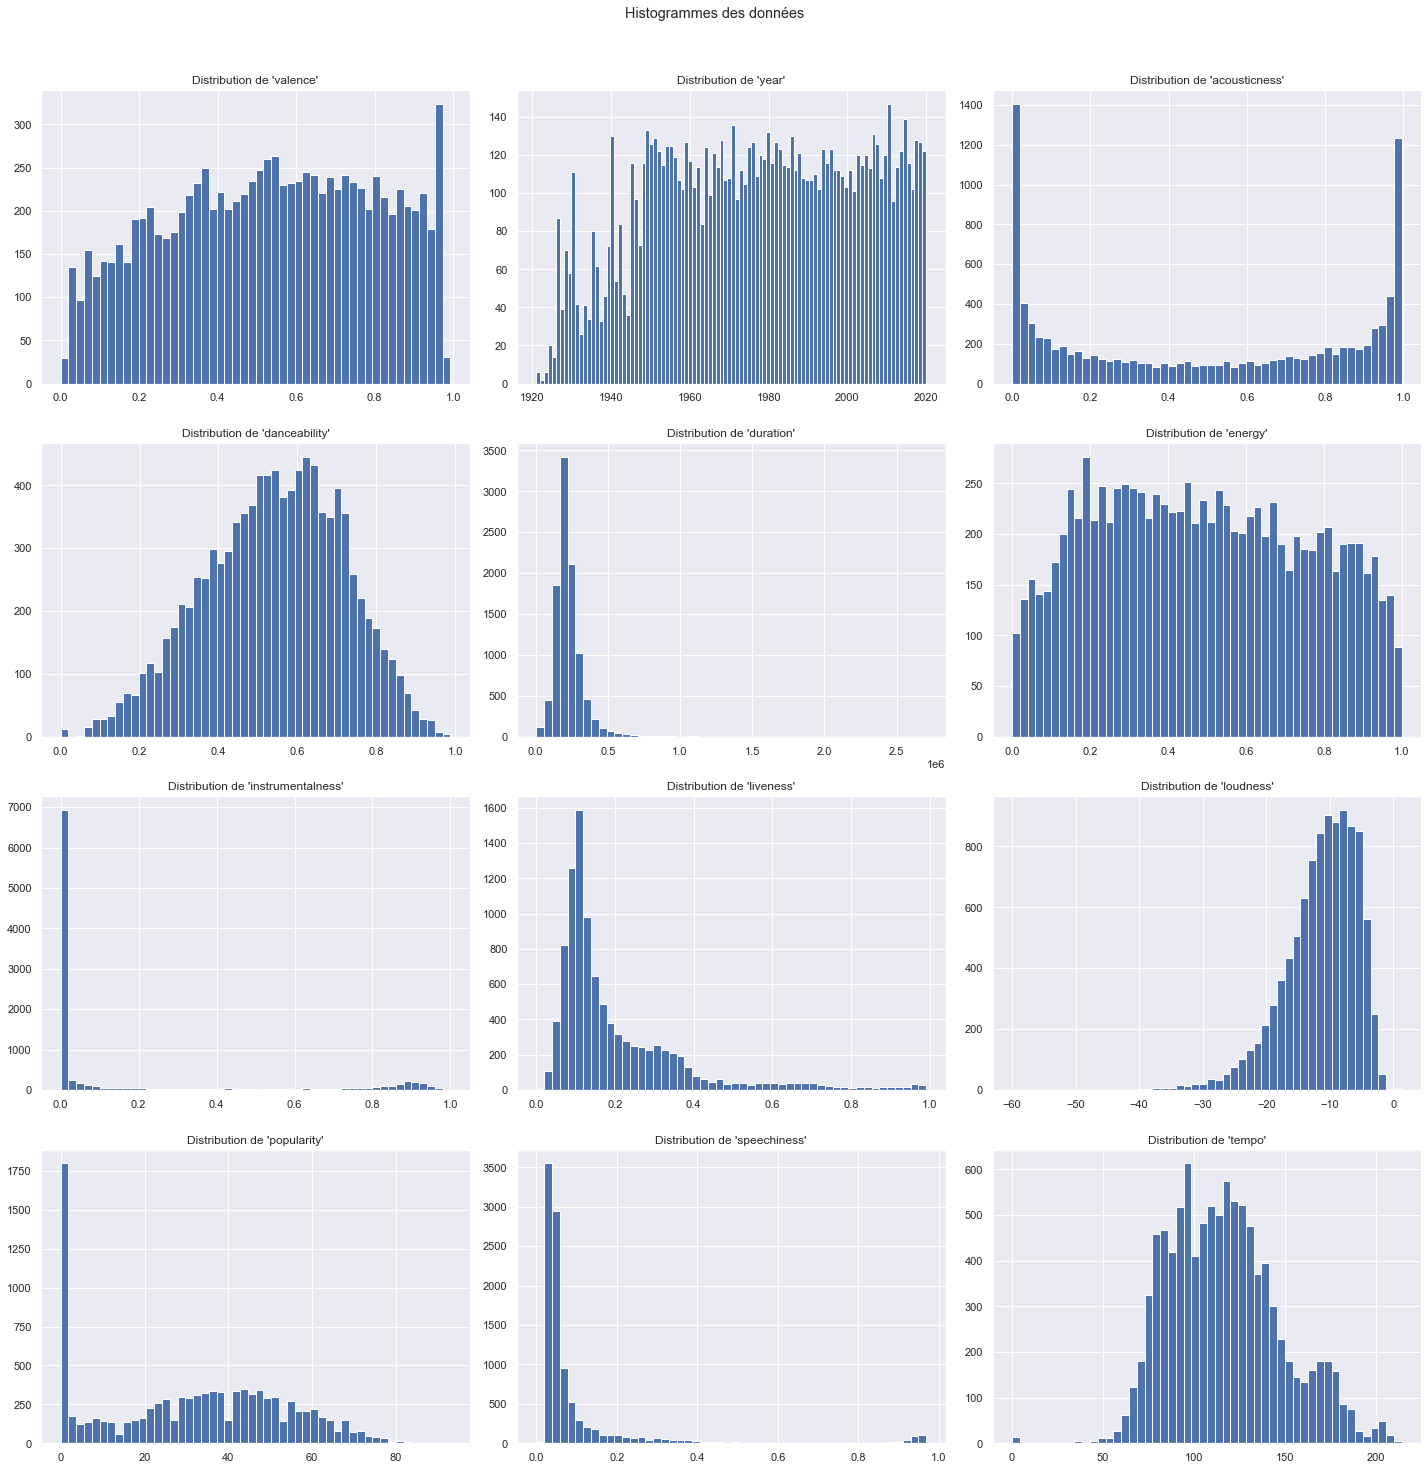

In [10]:
def histograms_plot(df, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i + 1)
        df[feature].hist(bins=50 if i != 1 else 100, ax=ax)
        ax.set_title("Distribution de '" + feature + "'")
    
    fig.suptitle("Histogrammes des données", y=1.02)
    save_fig("quantitative_data_histograms")

histograms_plot(data_quant, data_quant.columns, 4, 3)

Saving figure pop_class_frequencies


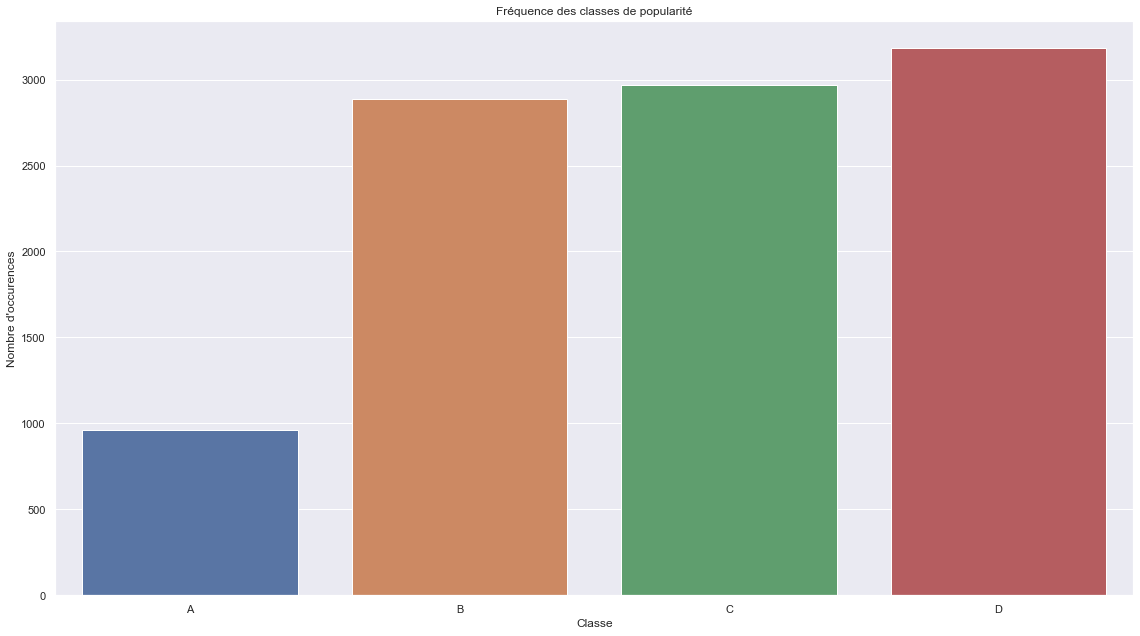

In [11]:
pop_class_count = spotify_data["pop.class"].value_counts()
sns.barplot(x=pop_class_count.index, y=pop_class_count.values)
plt.title("Fréquence des classes de popularité")
plt.ylabel("Nombre d'occurences")
plt.xlabel("Classe")
save_fig("pop_class_frequencies")
plt.show()

Saving figure keys_frequencies


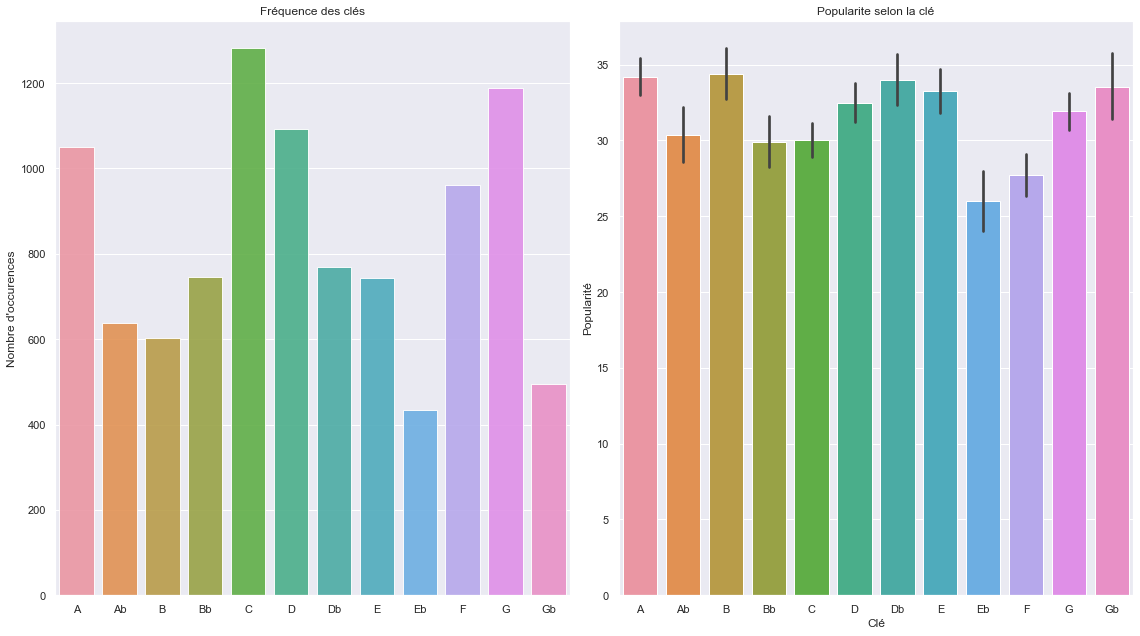

In [12]:
key_count = spotify_data["key"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

sns.barplot(ax=ax1, x=key_count.index, y=key_count.values, alpha=0.9)
ax1.set_title("Fréquence des clés")
ax1.set_ylabel("Nombre d'occurences")
ax2.set_xlabel("Clé")

sns.barplot(ax=ax2, x='key', y='popularity', data=spotify_data)
ax2.set_title("Popularite selon la clé")
ax2.set_ylabel("Popularité")
ax2.set_xlabel("Clé")

save_fig("keys_frequencies")
plt.show()

Saving figure mode_frequencies


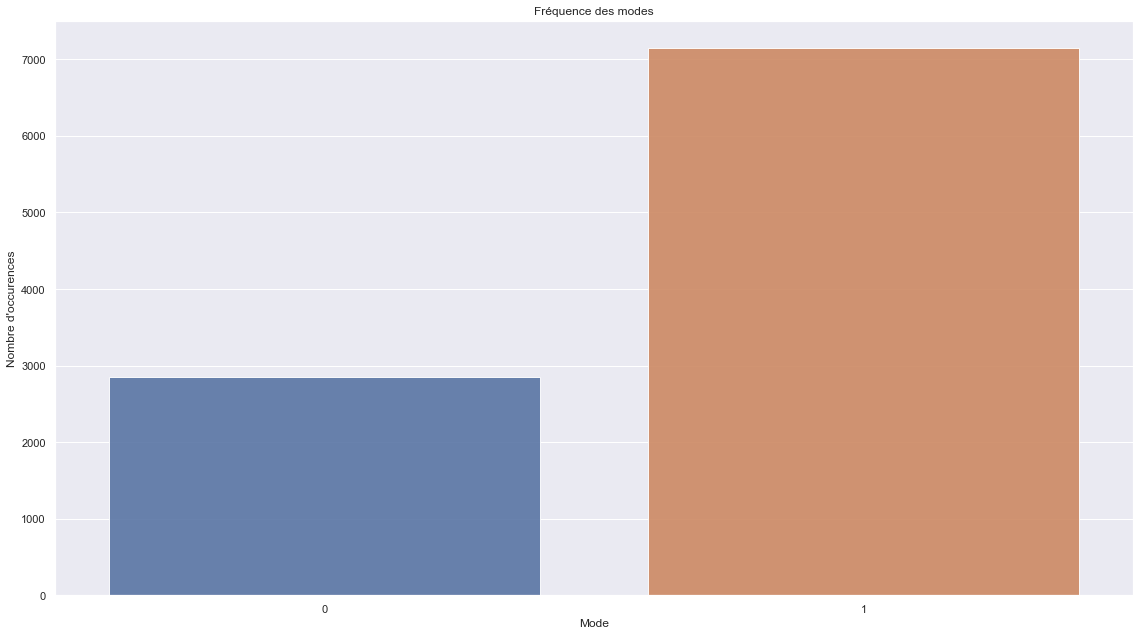

In [13]:
key_count = spotify_data["mode"].value_counts()
sns.barplot(x=key_count.index, y=key_count.values, alpha=0.9)
plt.title("Fréquence des modes")
plt.ylabel("Nombre d'occurences")
plt.xlabel("Mode")
save_fig("mode_frequencies")
plt.show()

Saving figure popularity_by_key_and_mode


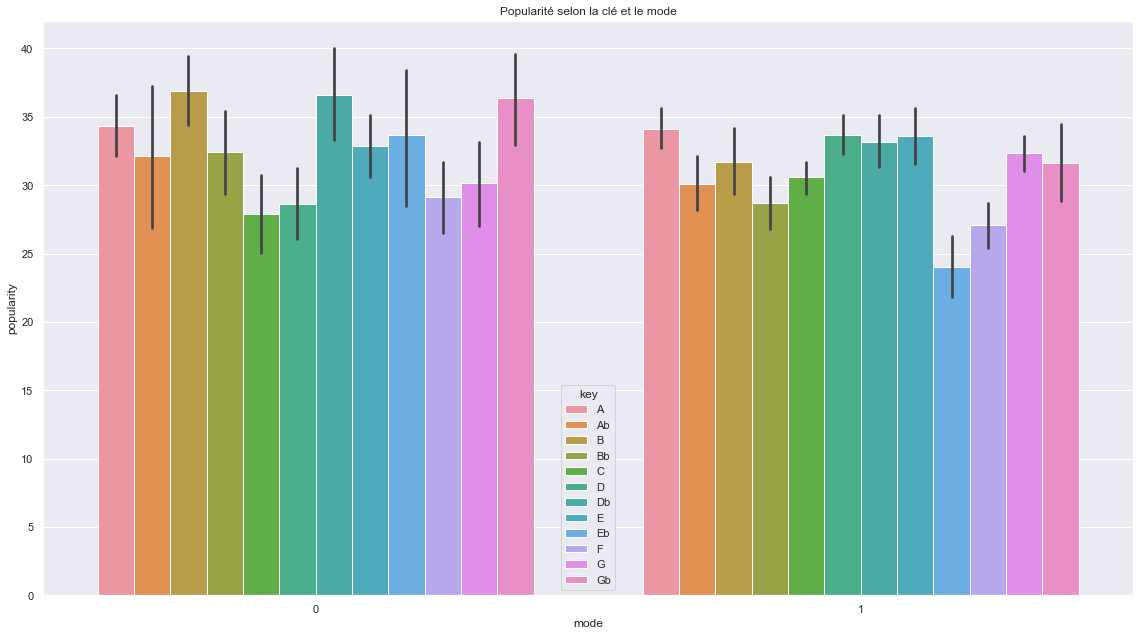

In [14]:
sns.barplot(x='mode', y='popularity', hue='key', data=spotify_data)
plt.title("Popularité selon la clé et le mode")
save_fig("popularity_by_key_and_mode")
plt.show()

Saving figure acousticness_by_energy


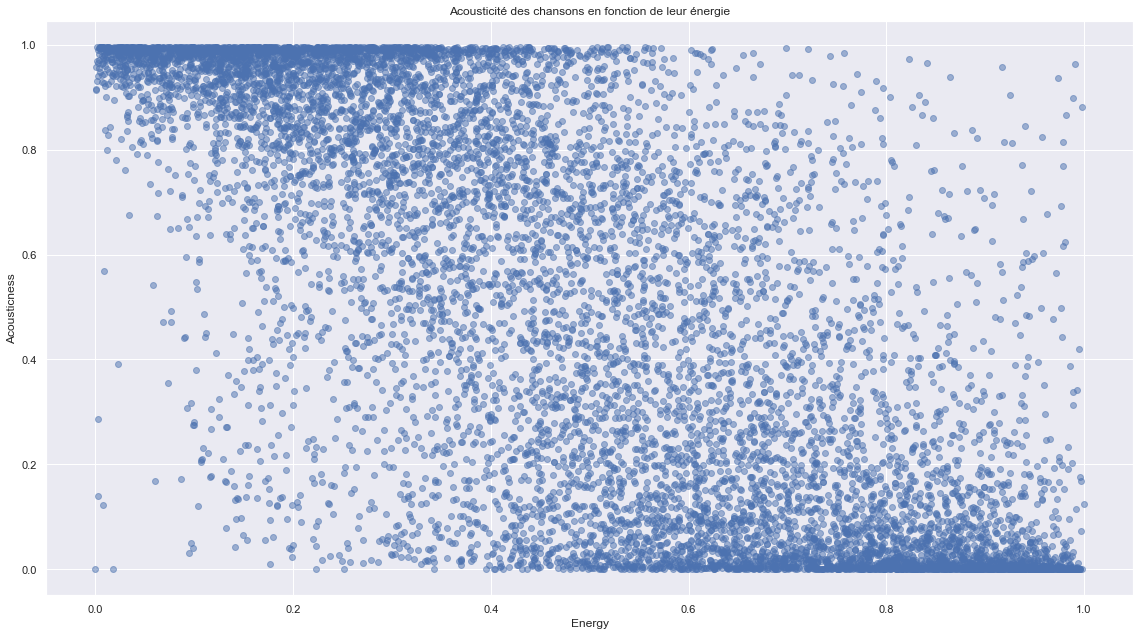

In [15]:
plt.scatter(spotify_data['energy'], spotify_data['acousticness'], alpha=.5)
plt.xlabel("Energy")
plt.ylabel("Acousticness")
plt.title("Acousticité des chansons en fonction de leur énergie")
save_fig("acousticness_by_energy")
plt.show()

Saving figure popularity_by_acousticness


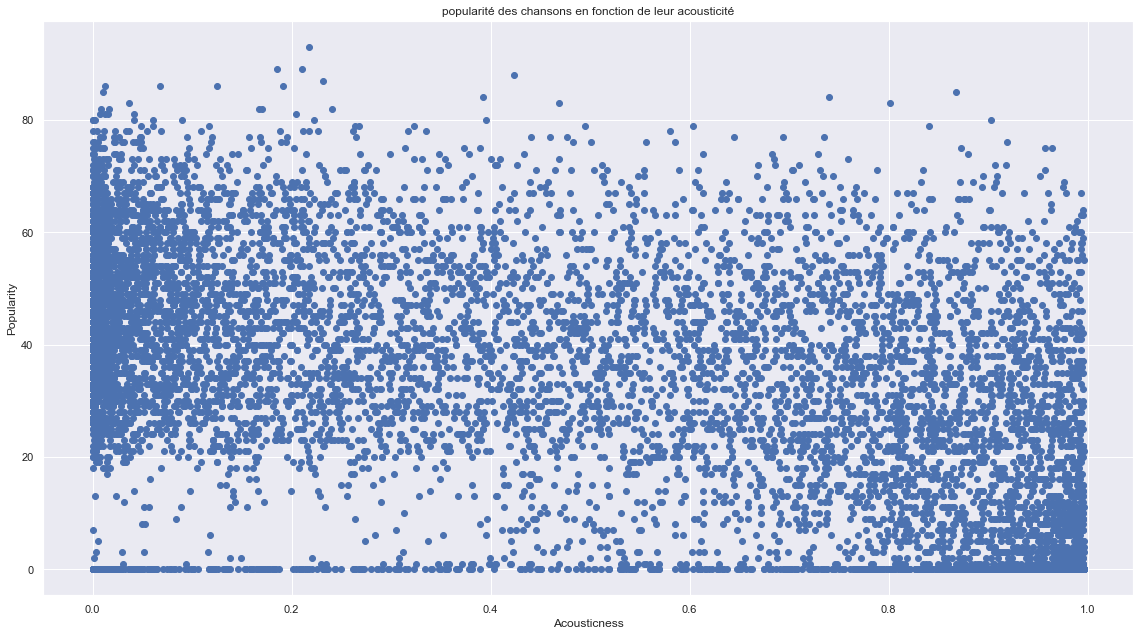

In [16]:
plt.scatter(spotify_data['acousticness'], spotify_data['popularity'])
plt.xlabel("Acousticness")
plt.ylabel("Popularity")
plt.title("popularité des chansons en fonction de leur acousticité")
save_fig("popularity_by_acousticness")
plt.show()

Saving figure log_of_duration


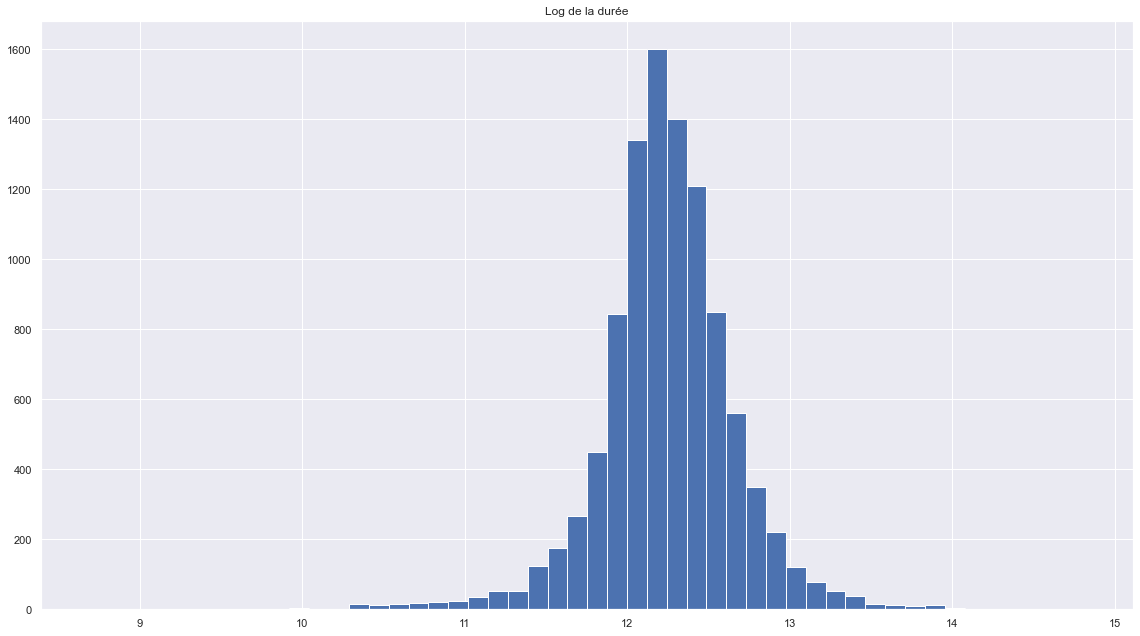

In [17]:
spotify_data["log_duration"] = np.log(spotify_data["duration"])
spotify_data["log_duration"].hist(bins=50)
plt.title("Log de la durée")
save_fig("log_of_duration")
plt.show()

Pour mieux visualiser la durée de la chanson, nous avons décidé de lui appliquer le logarithme naturel afin de réduire les valeurs, tout en gardant l'ordre de croissance.

Saving figure scaled_tempo


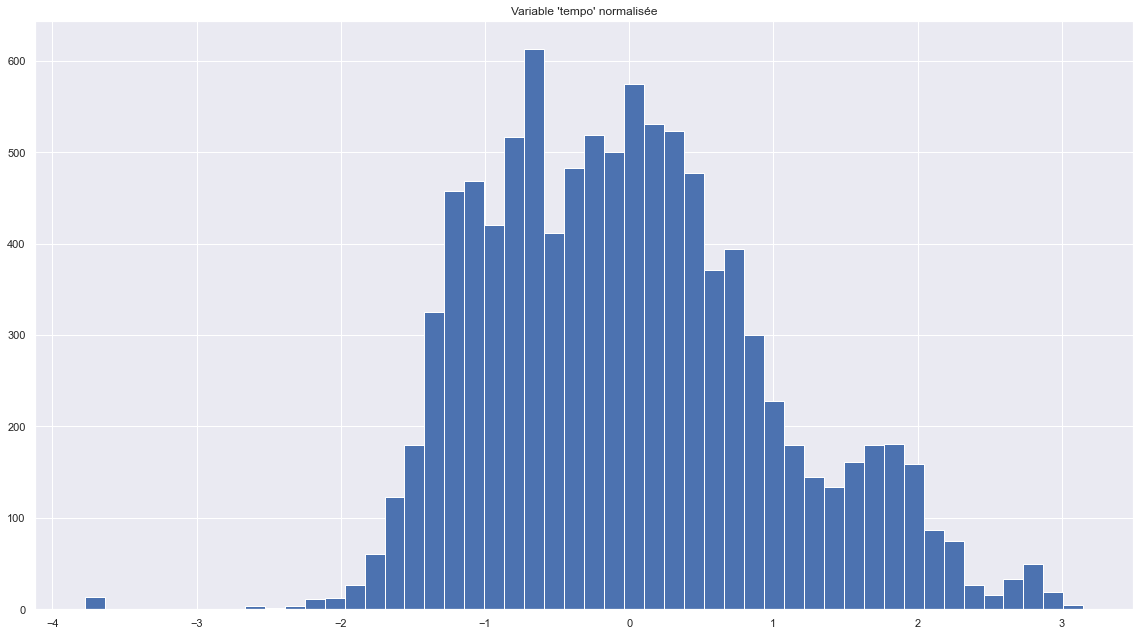

In [18]:
spotify_data["tempo_norm"] = (
    spotify_data["tempo"] -
    spotify_data["tempo"].mean()) / spotify_data["tempo"].std()
spotify_data["tempo_norm"].hist(bins=50)
plt.title("Variable 'tempo' normalisée")
save_fig("scaled_tempo")
plt.show()

Saving figure scaled_danceability


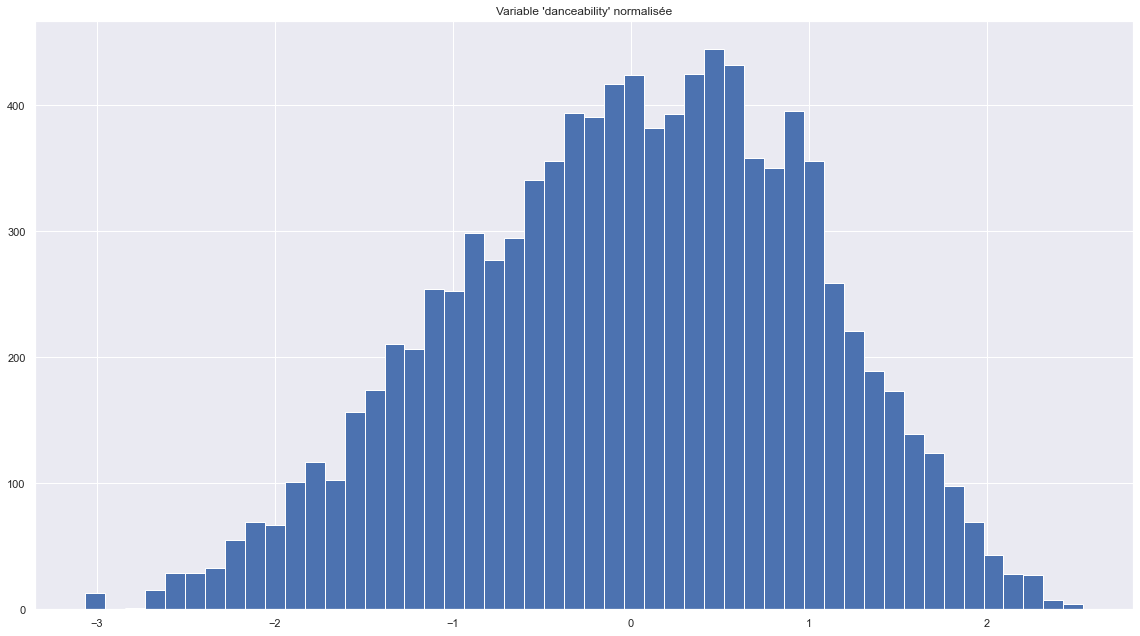

In [19]:
spotify_data["dance_norm"] = (
    spotify_data["danceability"] -
    spotify_data["danceability"].mean()) / spotify_data["danceability"].std()
spotify_data["dance_norm"].hist(bins=50)
plt.title("Variable 'danceability' normalisée")
save_fig("scaled_danceability")
plt.show()

In [20]:
del spotify_data["duration"]
del spotify_data["tempo"]
del spotify_data["danceability"]
spotify_data.head()

valence  year  acousticness  energy  instrumentalness key  liveness  \
161704    0.647  1975        0.4490   0.827          0.007880   B     0.466   
168077    0.150  2008        0.8990   0.169          0.000011  Ab     0.136   
35922     0.423  2007        0.0185   0.878          0.083900   B     0.276   
135823    0.302  1995        0.0384   0.980          0.552000   B     0.237   
165395    0.828  1994        0.5310   0.625          0.000008   G     0.348   

        loudness mode  popularity  speechiness pop.class  log_duration  \
161704    -7.604    1          25       0.3990         C     12.607664   
168077   -11.332    1          42       0.0553         B     12.374971   
35922     -5.576    0          65       0.0377         A     12.615174   
135823    -3.154    1          36       0.0721         C     11.864990   
165395   -11.963    0          38       0.0639         C     12.143133   

        tempo_norm  dance_norm  
161704    1.731060   -0.930965  
168077   -0.303166   -0.181784  
35922     1.072918   -0.397457  
135823    1.798579   -2.066086  
165395   -0.614638    0.936310

Saving figure pairplot_of_dataset


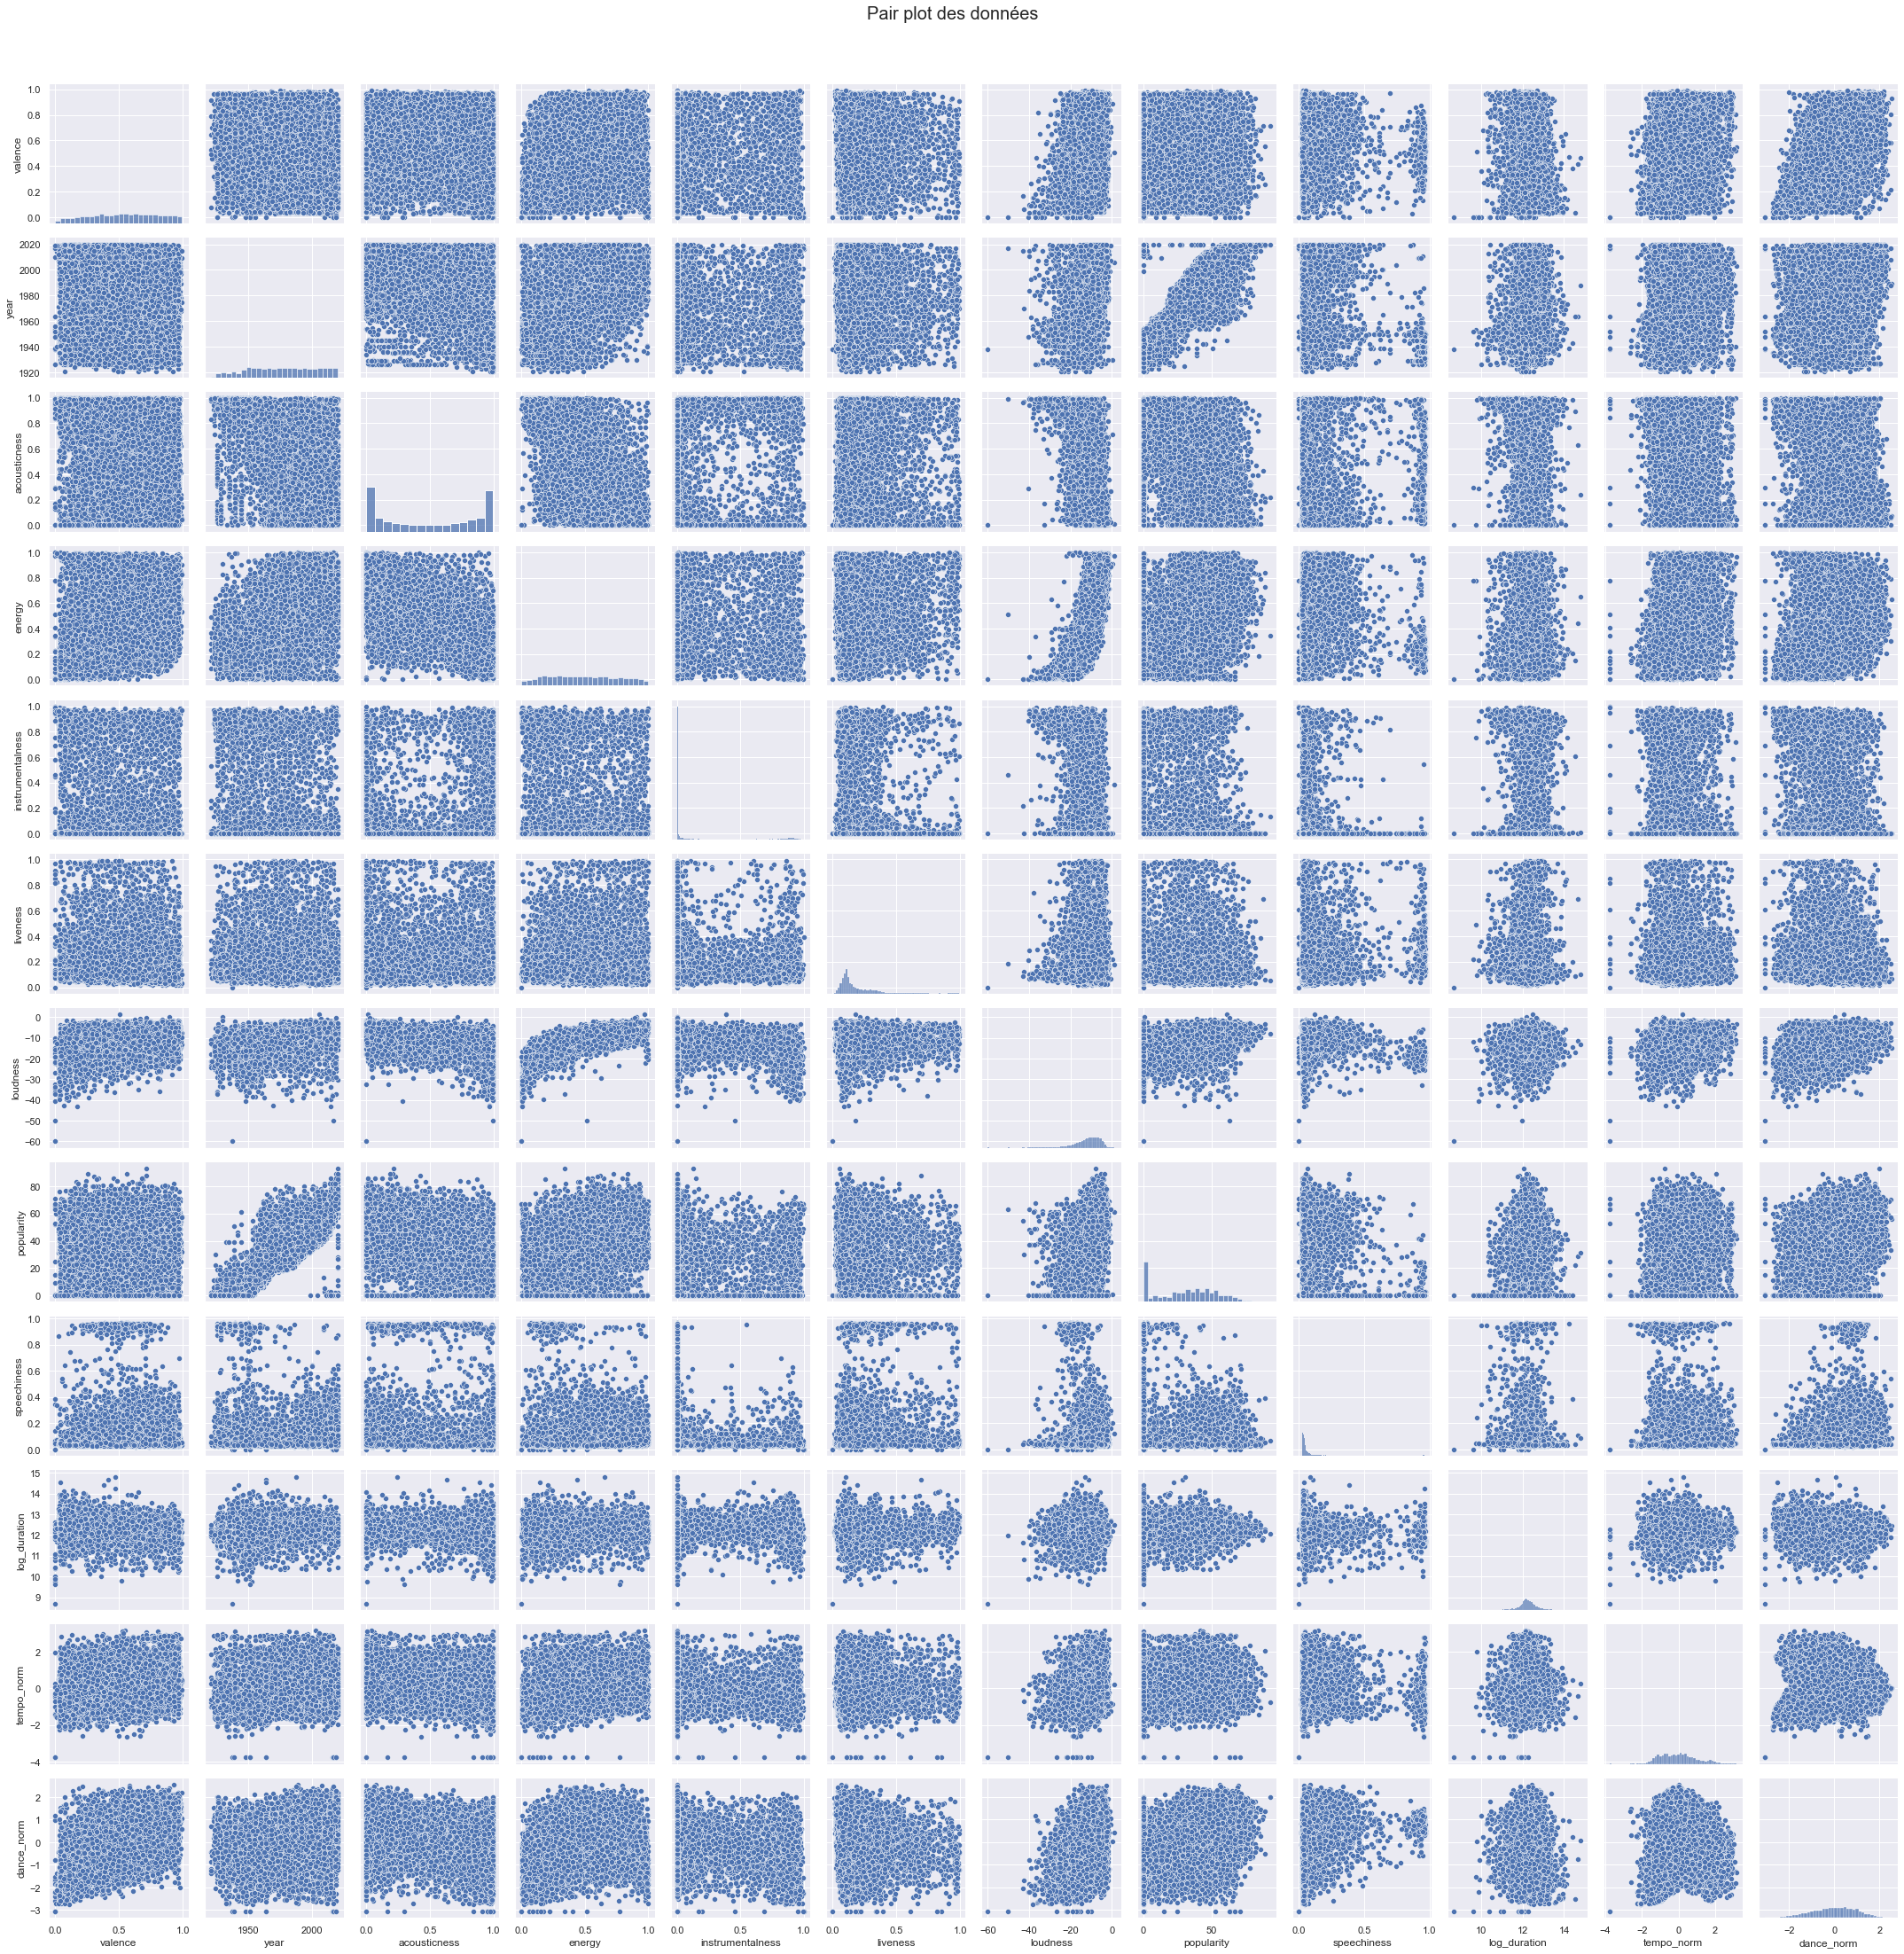

In [21]:
sns.pairplot(spotify_data)
plt.suptitle("Pair plot des données", fontsize=20, y=1.02)
save_fig("pairplot_of_dataset")
plt.show()

Saving figure correlation_square_matrix


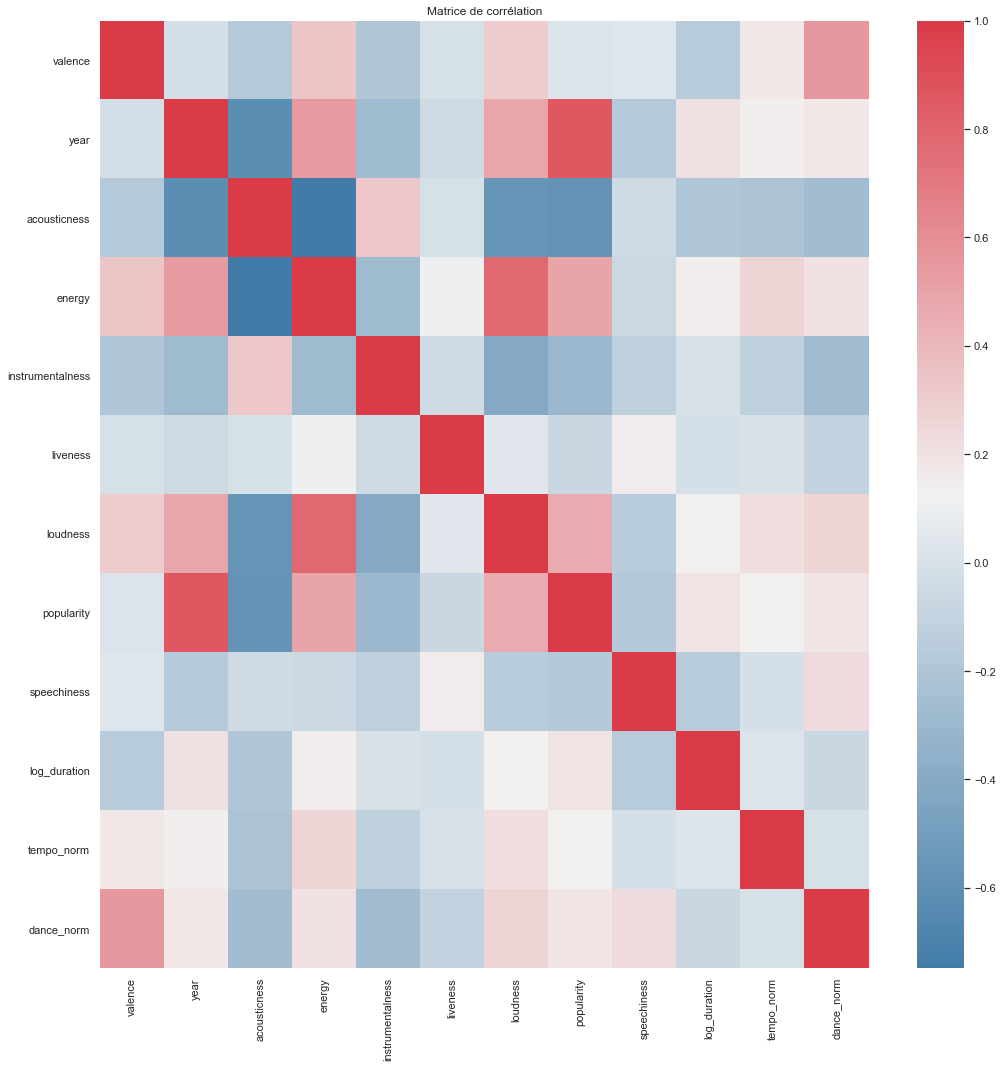

In [22]:
corr_matrix = spotify_data.corr()

cmap = sns.diverging_palette(240, 10, as_cmap=True)
plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap=cmap)
plt.title("Matrice de corrélation")
save_fig("correlation_square_matrix")
plt.show()

Ce graphique nous montre qu'il y a certaines variables qui ont une forte corrélation. Par exemple, il y a une forte corrélation négative entre les variables `energy` et `acousticness`. Cela a du sens vu que les chansons acoustiques sont plus tranquilles (moins énergiques) que celles qui ne sont pas acoustiques. De même, `energy` et `loudness` sont positivement corrélées, ce qui est attendu vu que les chansons bruyantes ont souvent plus d'énergie.
<br>
On voit aussi que plus une chanson est acoustique, moins elle est populaire, vu que les variables `acousticness` et `popularity` ont une forte corrélation négative.

Saving figure jointplot_of_popularity_by_year


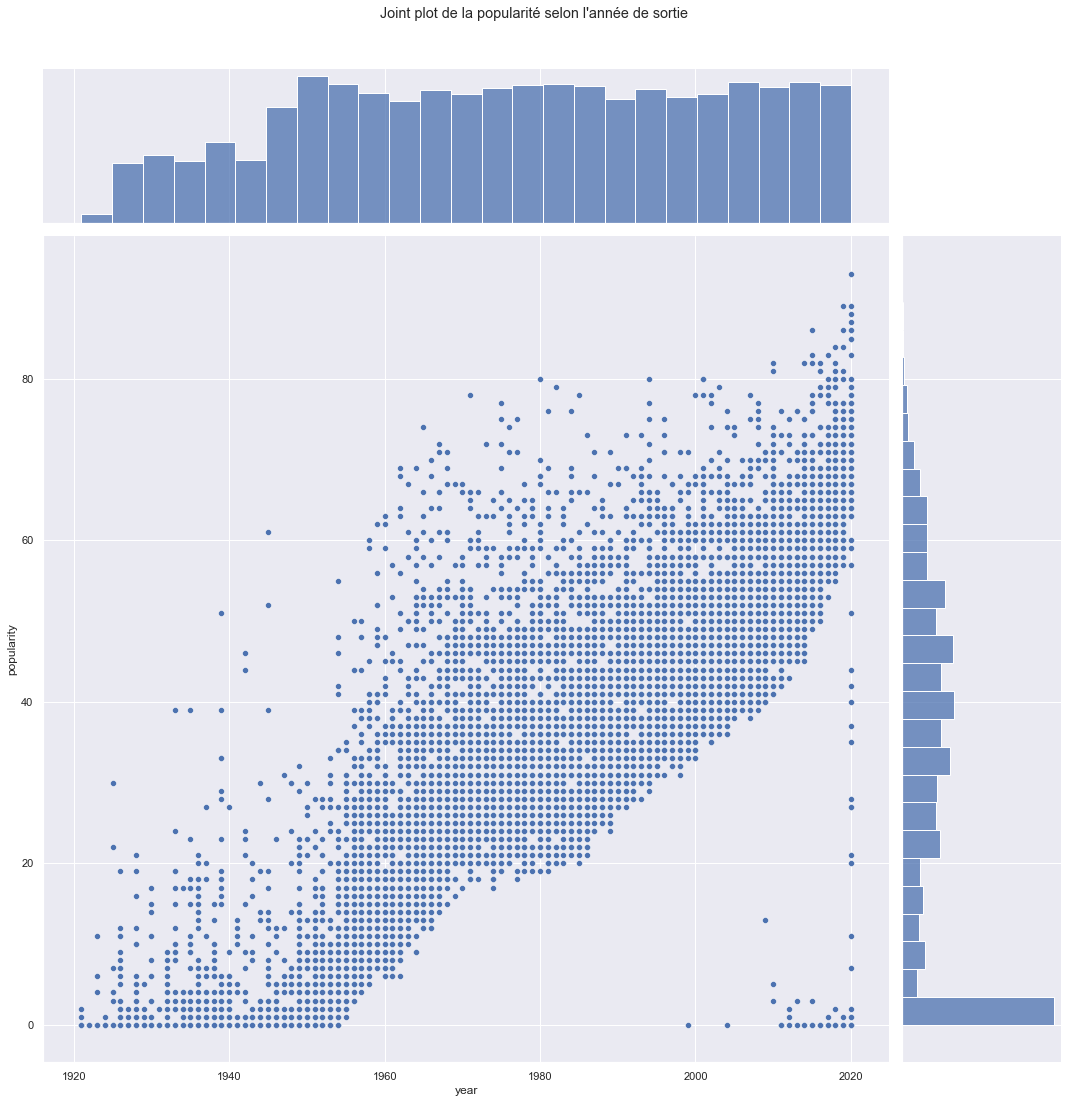

In [23]:
sns.jointplot(x='year', y='popularity', data=spotify_data, height=15)
plt.suptitle("Joint plot de la popularité selon l'année de sortie", y=1.02)
save_fig("jointplot_of_popularity_by_year")
plt.show()

Saving figure scatter_matrix_plot


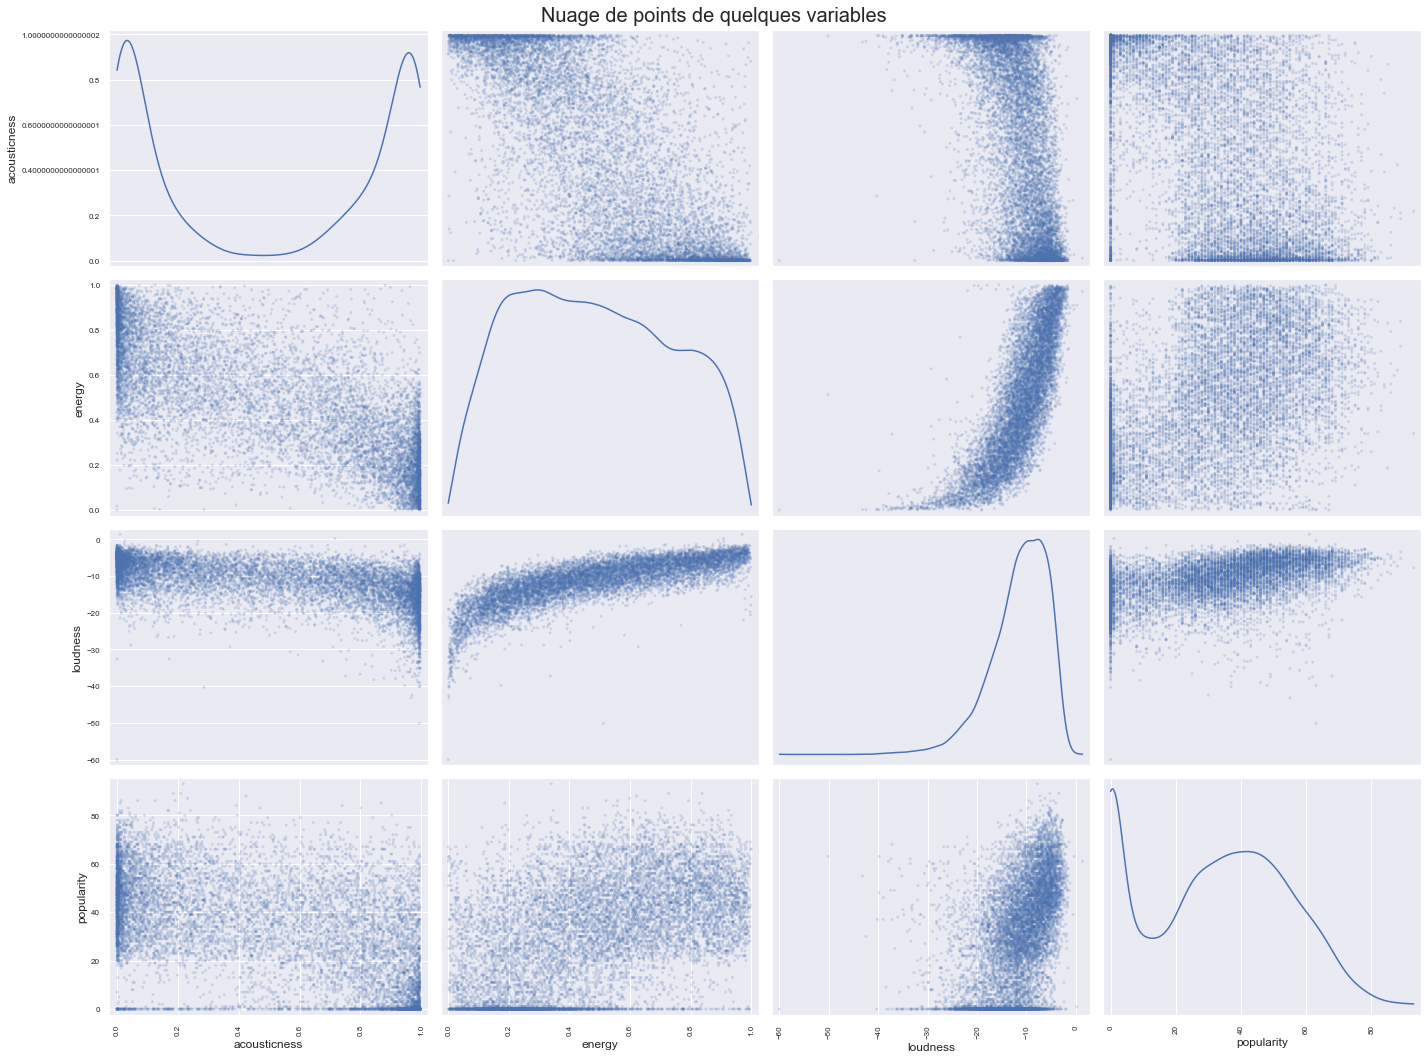

In [24]:
from pandas.plotting import scatter_matrix

attributes = ["acousticness", "energy", "loudness", "popularity"]
scatter_matrix(spotify_data[attributes],
               alpha=0.2,
               figsize=(20, 15),
               diagonal='kde')
plt.suptitle("Nuage de points de quelques variables", fontsize=20)
save_fig("scatter_matrix_plot")
plt.show()

# ACP

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

attributs = [
    feature for feature in spotify_data.keys()
    if feature not in data_qual.keys()
]
attributs.remove('popularity')
print(attributs)

X_scaled = scale(spotify_data[attributs])
pca = PCA()
C = pca.fit_transform(X_scaled)

['valence', 'year', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'log_duration', 'tempo_norm', 'dance_norm']


Saving figure explained_var_ratio_and_cumulative


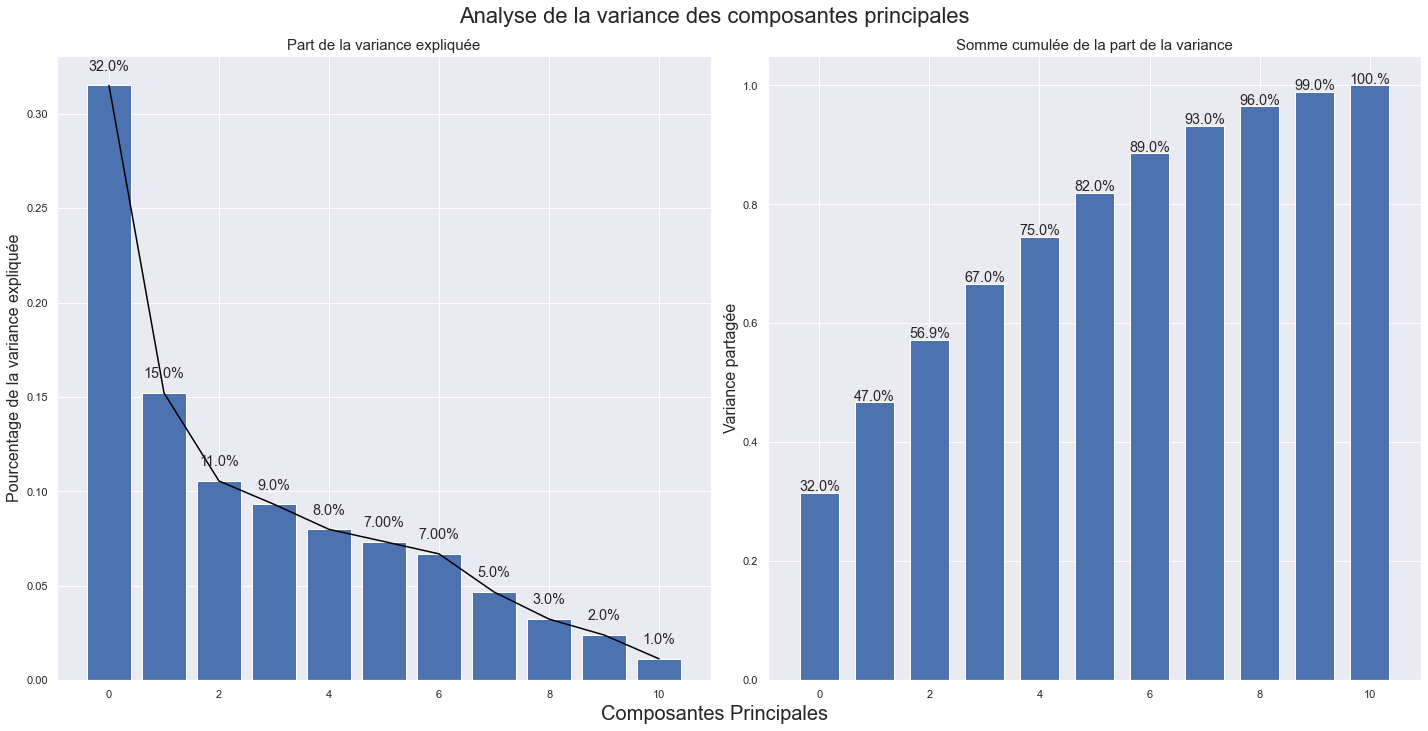

In [26]:
x = np.arange(pca.explained_variance_.size)
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True)

ax[0].bar(x, pca.explained_variance_ratio_)
ax[0].plot(pca.explained_variance_ratio_, color='black')
ax[0].set_ylabel("Pourcentage de la variance expliquée", fontsize=16)
ax[0].set_title("Part de la variance expliquée", fontsize=15)

for p in ax[0].patches:
    text = str(np.round(p.get_height(), 2) * 100)[:4] + '%'
    ax[0].annotate(text=text,
                   xy=(p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
                   fontsize='large',
                   ha='center',
                   va='center')

ax[1].bar(x, np.cumsum(pca.explained_variance_ratio_), width=.7)
ax[1].set_ylabel("Variance partagée", fontsize=16)
ax[1].set_title("Somme cumulée de la part de la variance", fontsize=15)

for p in ax[1].patches:
    text = str(np.round(p.get_height(), 2) * 100)[:4] + '%'
    ax[1].annotate(text=text,
                   xy=(p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
                   fontsize='large',
                   ha='center',
                   va='center')

fig.text(0.5, -0.01, "Composantes Principales", ha='center', fontsize=20)
plt.suptitle("Analyse de la variance des composantes principales", fontsize=22)
save_fig("explained_var_ratio_and_cumulative")
plt.show()

Saving figure boxplot_of_variances


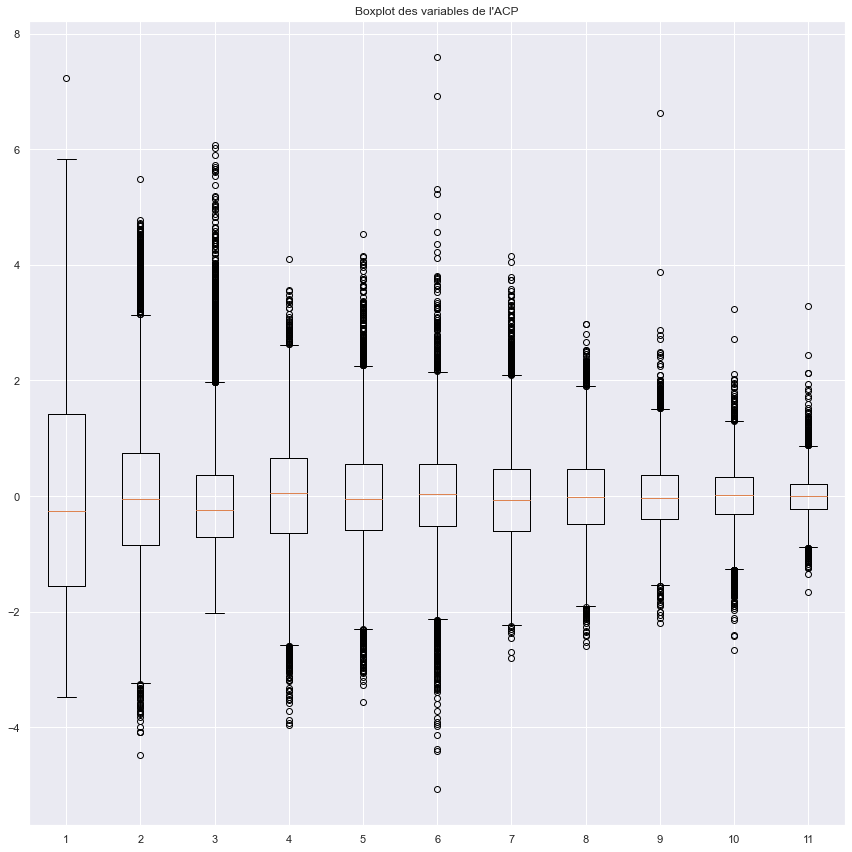

In [27]:
plt.figure(figsize=(12, 12))
plt.boxplot(C)
plt.title("Boxplot des variables de l'ACP")
save_fig("boxplot_of_variances")
plt.show()

1. Sélection de variables :
On sélectionne les 6 premières composantes principales.
Variance expliquée par les valeurs propres : 80% de variance expliquée à partir de 6 CP
On observe un coude sur le graphe des variances expliquées à partir de la 6e CP.
Boxplots : étendue des boxplots relativement stable à partir de la 5 ou 6e CP, la médiane des boxplots devient relativement identique.

Saving figure scatterplot_of_individuals


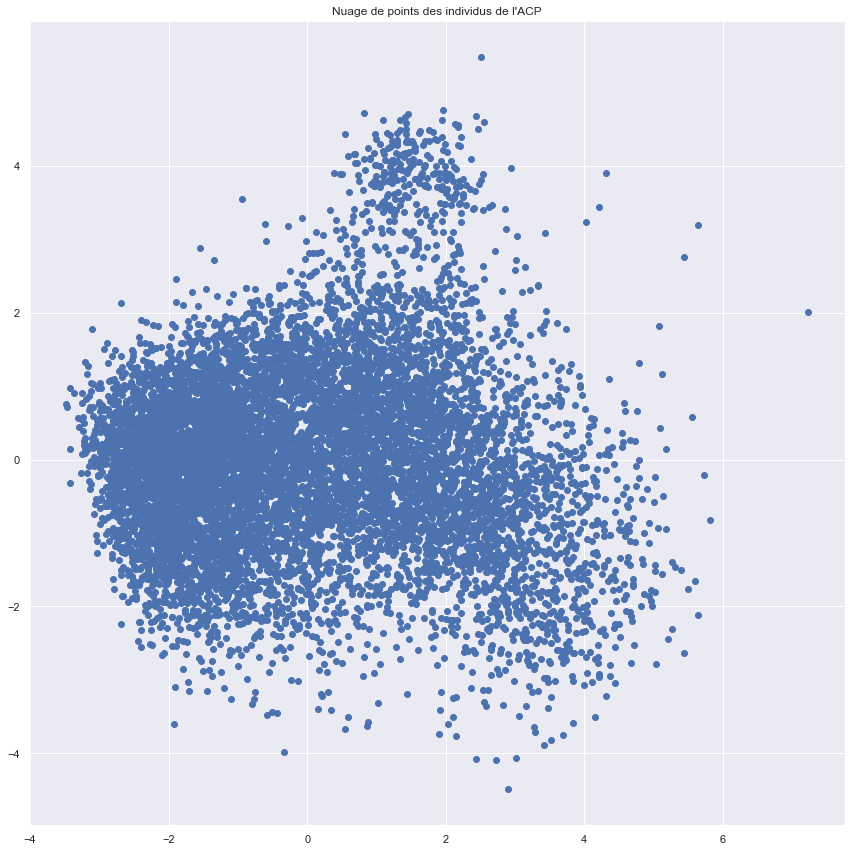

In [28]:
plt.figure(figsize=(12, 12))
plt.scatter(C[:, 0], C[:, 1])
plt.title("Nuage de points des individus de l'ACP")
save_fig("scatterplot_of_individuals")
plt.show()

2. Nuage de points des individus:
On observe 2 groupes distincts : 1 grand et un plus petit.

Saving figure pca_components_1_2


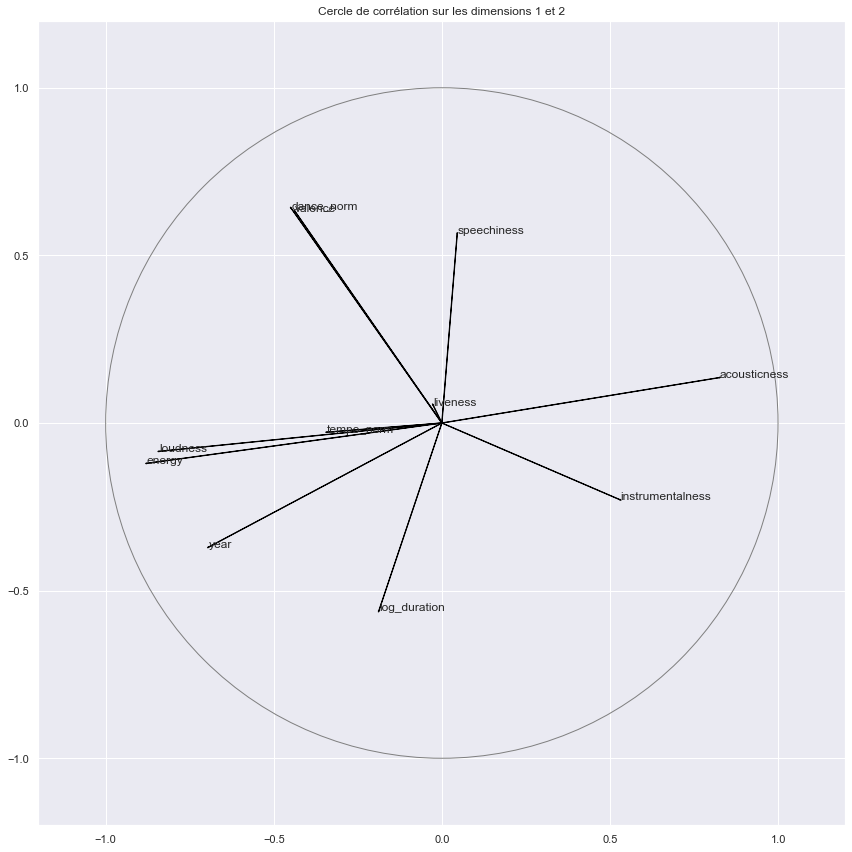

In [29]:
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord2 = pca.components_[1] * np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord2, spotify_data[attributs].columns):
    plt.text(i, j, nom)
    plt.arrow(0, 0, i, j, color='black')
plt.axis((-1.2, 1.2, -1.2, 1.2))

# cercle
c = plt.Circle((0, 0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.title("Cercle de corrélation sur les dimensions 1 et 2")
save_fig("pca_components_1_2")
plt.show()

Saving figure pca_components_1_3


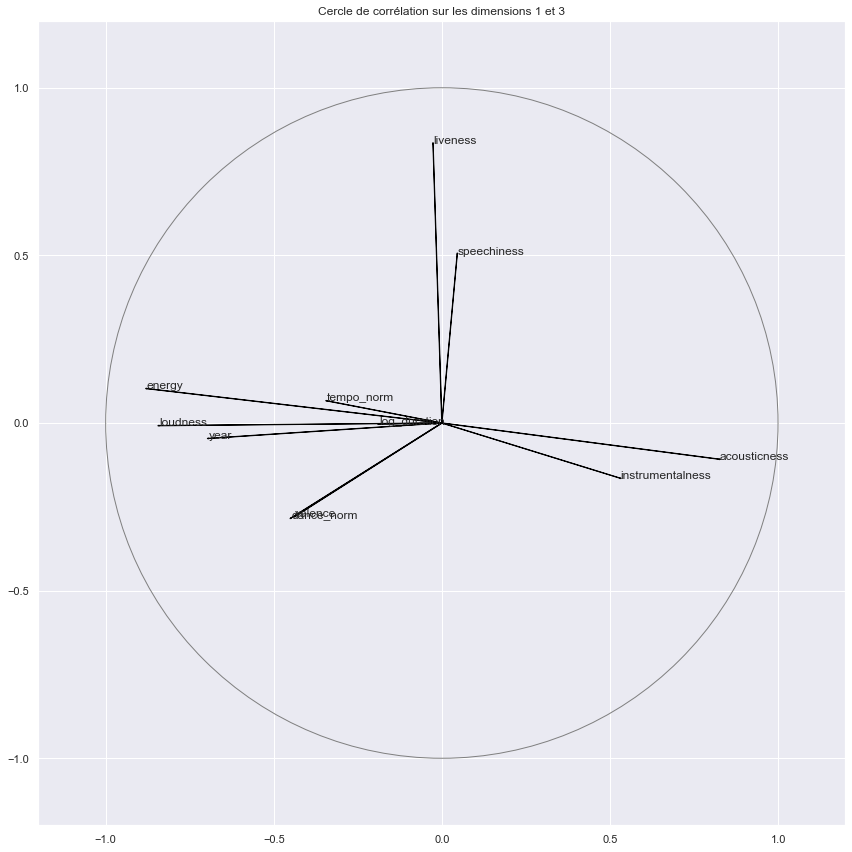

In [30]:
coord1 = pca.components_[0] * np.sqrt(pca.explained_variance_[0])
coord3 = pca.components_[2] * np.sqrt(pca.explained_variance_[2])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1, coord3, spotify_data[attributs].columns):
    plt.text(i, j, nom)
    plt.arrow(0, 0, i, j, color='black')
plt.axis((-1.2, 1.2, -1.2, 1.2))

# cercle
c = plt.Circle((0, 0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.title("Cercle de corrélation sur les dimensions 1 et 3")
save_fig("pca_components_1_3")
plt.show()

3. Cercle des correlations  (dim 1 et dim 2):
Axe des abscisses : Dimension 1
Axe des ordonnées : Dimension 2

Variables représentées par les flèches.

Speechiness : entièrement expliquée par la dimension 2.
Log_duration et speechiness sont très proches de l'axe des ordonnées : variables expliquées en majorité par la dimension 2.
Instrumentalness, accousticness, loudness: essetiellement expliquées par la dimension 1.

Accousticness et loudness : flèches sur le même axe. Variables inversement corrélées. En accord avec le graphe des corrélations.

Axe 2 : "divise" les flèches en 2 ?
A droite du graphe : dans les valeurs positives, on retrouve les chansons plus calmes / accoustiques / instrumentales
A gauche du graphe : dans les valeurs négatives , on retrouve les chansons plus "loud", dançantes

# Préparation des données

In [31]:
spotify_pop_class = spotify_data[["pop.class"]]
spotify_key = spotify_data[["key"]]

In [32]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_encoder = OrdinalEncoder()
spotify_pop_class_encoded = ordinal_encoder.fit_transform(spotify_pop_class)
spotify_pop_class_encoded = np.reshape(spotify_pop_class_encoded,
                                       spotify_data.shape[0]).astype(int)
print(spotify_pop_class_encoded[:10])

[2 1 0 2 2 0 1 1 0 1]


In [33]:
label_encoder = LabelEncoder()
spotify_key_encoded = label_encoder.fit_transform(spotify_key.values.ravel())
print(spotify_key_encoded[:10])

[ 2  1  2  2 10  5 10  7  5  9]


In [34]:
spotify_data["key"] = spotify_key_encoded
spotify_data["pop.class"] = spotify_pop_class_encoded

In [35]:
features = [
    feature for feature in spotify_data.keys() if feature not in ['popularity', 'pop.class']
]
print(features)

X = spotify_data[features]
y_class = spotify_data[["pop.class"]]
y_reg = spotify_data[["popularity"]]
y_class = y_class.values.ravel()
y_reg = y_reg.values.ravel()

['valence', 'year', 'acousticness', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'log_duration', 'tempo_norm', 'dance_norm']


In [36]:
X.head()

valence  year  acousticness  energy  instrumentalness  key  liveness  \
161704    0.647  1975        0.4490   0.827          0.007880    2     0.466   
168077    0.150  2008        0.8990   0.169          0.000011    1     0.136   
35922     0.423  2007        0.0185   0.878          0.083900    2     0.276   
135823    0.302  1995        0.0384   0.980          0.552000    2     0.237   
165395    0.828  1994        0.5310   0.625          0.000008   10     0.348   

        loudness mode  speechiness  log_duration  tempo_norm  dance_norm  
161704    -7.604    1       0.3990     12.607664    1.731060   -0.930965  
168077   -11.332    1       0.0553     12.374971   -0.303166   -0.181784  
35922     -5.576    0       0.0377     12.615174    1.072918   -0.397457  
135823    -3.154    1       0.0721     11.864990    1.798579   -2.066086  
165395   -11.963    0       0.0639     12.143133   -0.614638    0.936310

In [37]:
print(y_reg[:5])
print(y_class[:15])

[25 42 65 36 38]
[2 1 0 2 2 0 1 1 0 1 3 1 2 3 3]


# Apprentissage

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Classification

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

In [40]:
classes = ['A', 'B', 'C', 'D']

In [41]:
from matplotlib.patches import Patch
import itertools
from collections import deque
from statsmodels.graphics.mosaicplot import mosaic

def nclass_classification_mosaic_plot(n_classes, results):
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prediction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)] * 2
    mosaic_tuples = tuple(itertools.product(*class_lists))

    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t: res_list[i] for i, t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(11, 10))
    #plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
#     pallet = [
#         '#6a89cc',
#         '#4a69bd',
#         '#1e3799',
#         '#0c2461',
#         '#82ccdd',
#         '#60a3bc',
#     ]
    pallet = [
        '#1F77B4',
        '#E41A1C',
        '#4DAF4A',
        '#984EA3'
    ]
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)): {
        'color': all_colors[i]} for i, (a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ''

    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {'fontsize': 16, 'color': font_color}
    axis_label_font_dict = {'fontsize': 12, 'color': font_color}

    ax.tick_params(axis="x", which="both", bottom=False, top=False)
    ax.axes.yaxis.set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=14)

    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [
        Patch(facecolor=all_colors[i], label='Class {}'.format(chr(65+i)))
        for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1.018), fontsize=16)

    plt.tight_layout()
    plt.show()

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cf_matrix(y_true, y_pred, classes, **kwargs):
    cf_mx = confusion_matrix(y_true, y_pred, normalize=None)
    plt.figure(figsize=(15, 15))
    cm = ConfusionMatrixDisplay(cf_mx, display_labels=classes).plot(**kwargs)
    # enlever les lignes suivantes si pas de mosaique
    n_classes = 4
    cf_mx = cf_mx.tolist()
    nclass_classification_mosaic_plot(n_classes, cf_mx)

In [43]:
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.25, random_state=42)

In [44]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Régression logistique

#### Multinomiale

#### OVR

### Random Forest

### LinearSVC

#### OVR

In [45]:
LSVC_Model = LinearSVC(multi_class='ovr', max_iter=4000, random_state=42)
LSVC_Model.fit(X_train_scaled, y_train_class)
LSVC_Prediction = LSVC_Model.predict(X_test_scaled)

<Figure size 1080x1080 with 0 Axes>

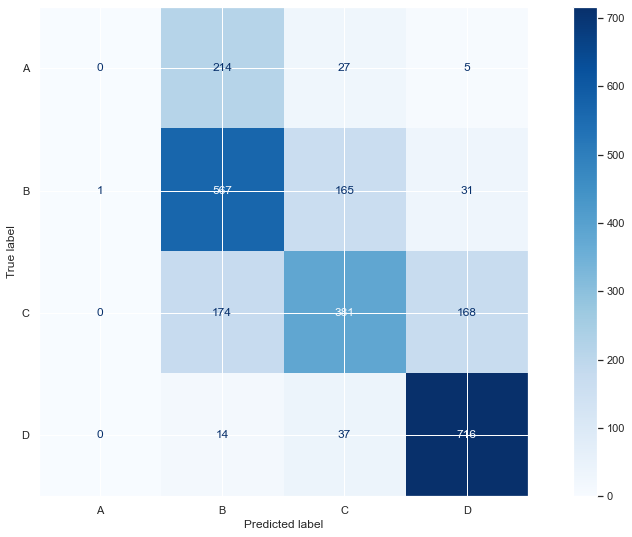

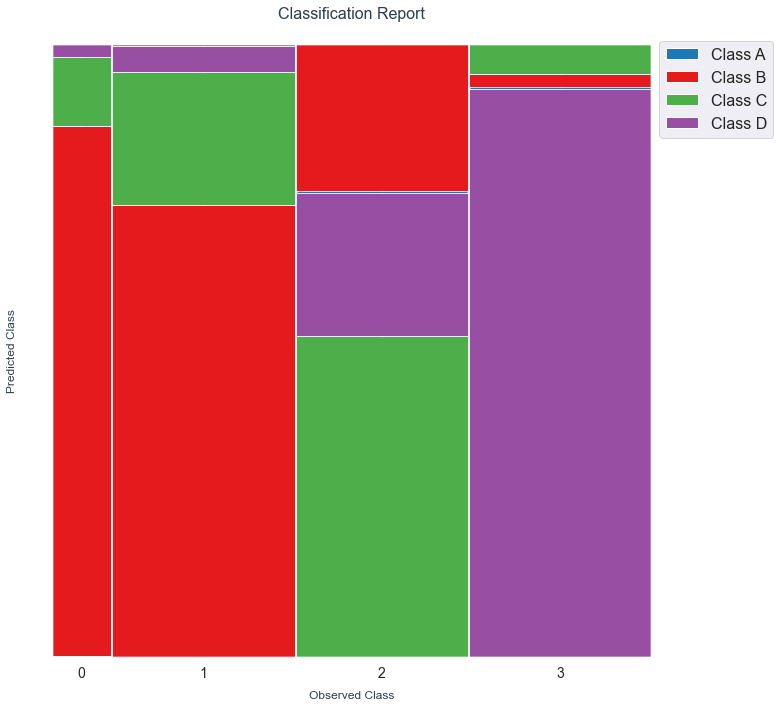

In [46]:
plot_cf_matrix(y_test_class, LSVC_Prediction, classes, cmap='Blues')

In [47]:
print(classification_report(y_test_class, LSVC_Prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.59      0.74      0.65       764
           2       0.62      0.53      0.57       723
           3       0.78      0.93      0.85       767

    accuracy                           0.67      2500
   macro avg       0.50      0.55      0.52      2500
weighted avg       0.60      0.67      0.63      2500



#### Crammer-Singer

In [48]:
LSVC_Model = LinearSVC(multi_class='crammer_singer', max_iter=4000, random_state=42)
LSVC_Model.fit(X_train_scaled, y_train_class)
LSVC_Prediction = LSVC_Model.predict(X_test_scaled)

C:\Users\luis_\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 1080x1080 with 0 Axes>

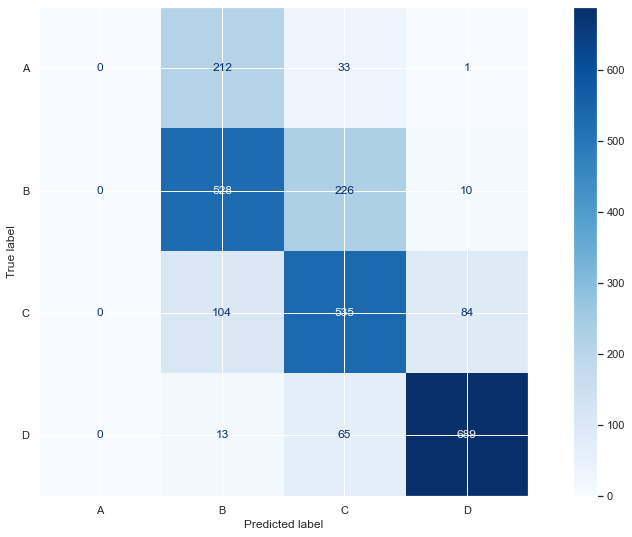

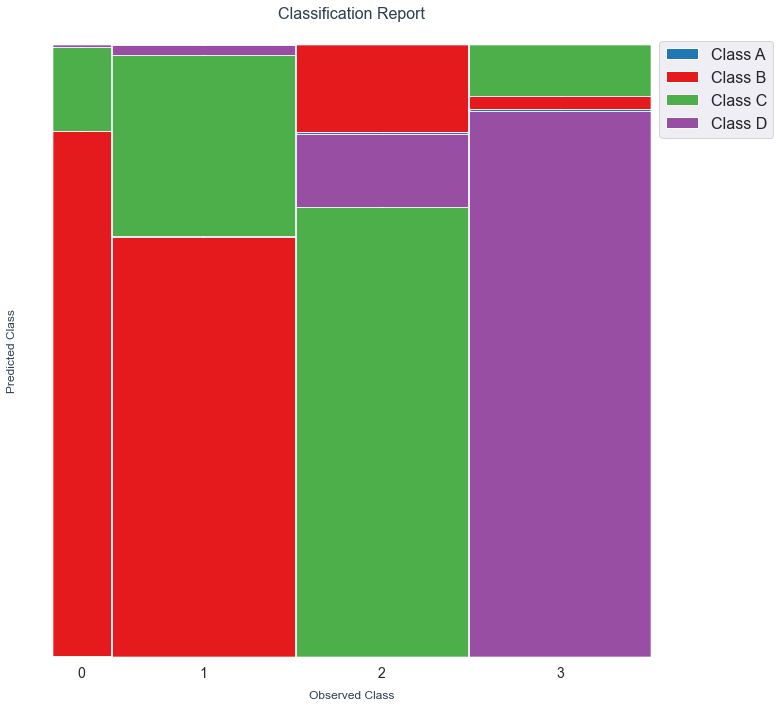

In [49]:
plot_cf_matrix(y_test_class, LSVC_Prediction, classes, cmap='Blues')

In [50]:
print(classification_report(y_test_class, LSVC_Prediction, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.62      0.69      0.65       764
           2       0.62      0.74      0.68       723
           3       0.88      0.90      0.89       767

    accuracy                           0.70      2500
   macro avg       0.53      0.58      0.55      2500
weighted avg       0.64      0.70      0.67      2500



### SVC

In [51]:
SVC_Model = SVC(C=2., random_state=42)
SVC_Model.fit(X_train_scaled, y_train_class)
SVC_Prediction = SVC_Model.predict(X_test_scaled)

<Figure size 1080x1080 with 0 Axes>

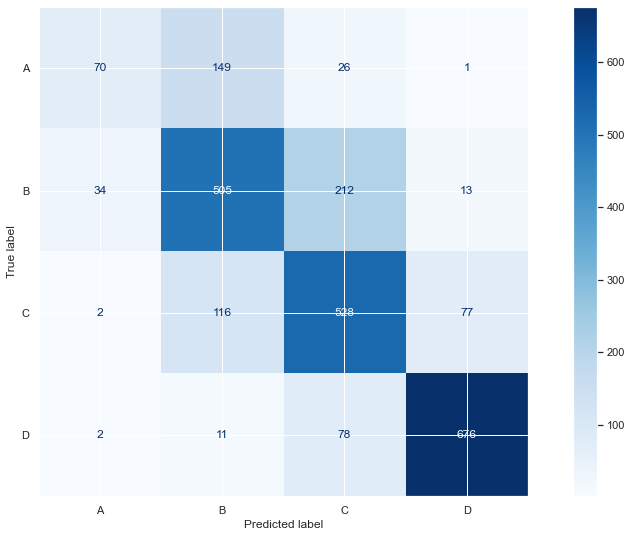

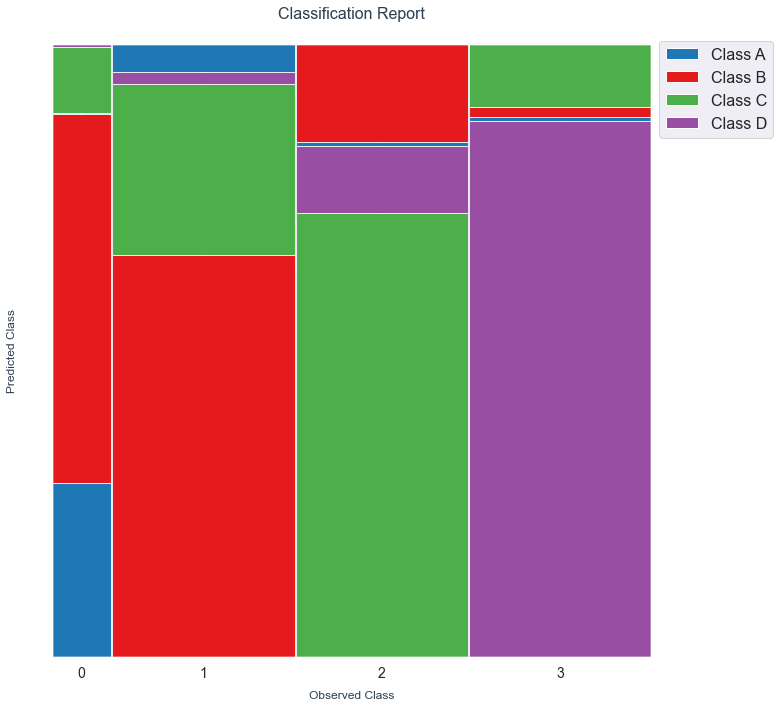

In [52]:
plot_cf_matrix(y_test_class, SVC_Prediction, classes, cmap='Blues')

In [53]:
print(classification_report(y_test_class, SVC_Prediction))

              precision    recall  f1-score   support

           0       0.65      0.28      0.40       246
           1       0.65      0.66      0.65       764
           2       0.63      0.73      0.67       723
           3       0.88      0.88      0.88       767

    accuracy                           0.71      2500
   macro avg       0.70      0.64      0.65      2500
weighted avg       0.71      0.71      0.70      2500



### Réseaux de neuronnes

In [54]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train_class)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=   0.0s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=   0.0s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=   0.0s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=   0.0s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=   0.0s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=   0.0s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=   0.0s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=   0.0s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=   0.0s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=   0.0s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=   0.0s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [55]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [56]:
grid_search.best_score_

0.694

In [57]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test_class, y_pred)

0.698

## Régression

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

reg_metrics = (mean_squared_error, r2_score, explained_variance_score)

In [59]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.25, random_state=42)

In [60]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
def reg_to_class(y_pred):
    n = len(y_pred)
    y_reg_to_class = np.zeros(n)
    for i in range(n):
        if 0 <= y_pred[i] < 20:
            y_reg_to_class[i] = 3
        elif 20 <= y_pred[i] < 40:
            y_reg_to_class[i] = 2
        elif 40 <= y_pred[i] < 60:
            y_reg_to_class[i] = 1
        else:
            y_reg_to_class[i] = 0

    return y_reg_to_class

In [62]:
def plot_results(metrics, y_true_reg, y_true_class, y_pred, title):
    x = np.linspace(0, 100, 200)
    for metric in metrics:
        print(metric.__name__.replace('_', ' ').title(),
              round(metric(y_true_reg, y_pred), 3))
    print("\nConverting regression to classification...")
    y_reg_to_class = reg_to_class(y_pred)
    print("Accuracy score:", accuracy_score(y_true_class, y_reg_to_class))
    
    plt.plot(x, x, c='red', linestyle='--')
    plt.scatter(y_true_reg, y_pred)
    plt.title("Results of " + title + " Prediction")
    save_fig("results_of_" + title + "_prediction")
    plt.show()

### Régression linéaire

Mean Squared Error 115.129
R2 Score 0.758
Explained Variance Score 0.758

Converting regression to classification...
Accuracy score: 0.672
Saving figure results_of_LR_prediction


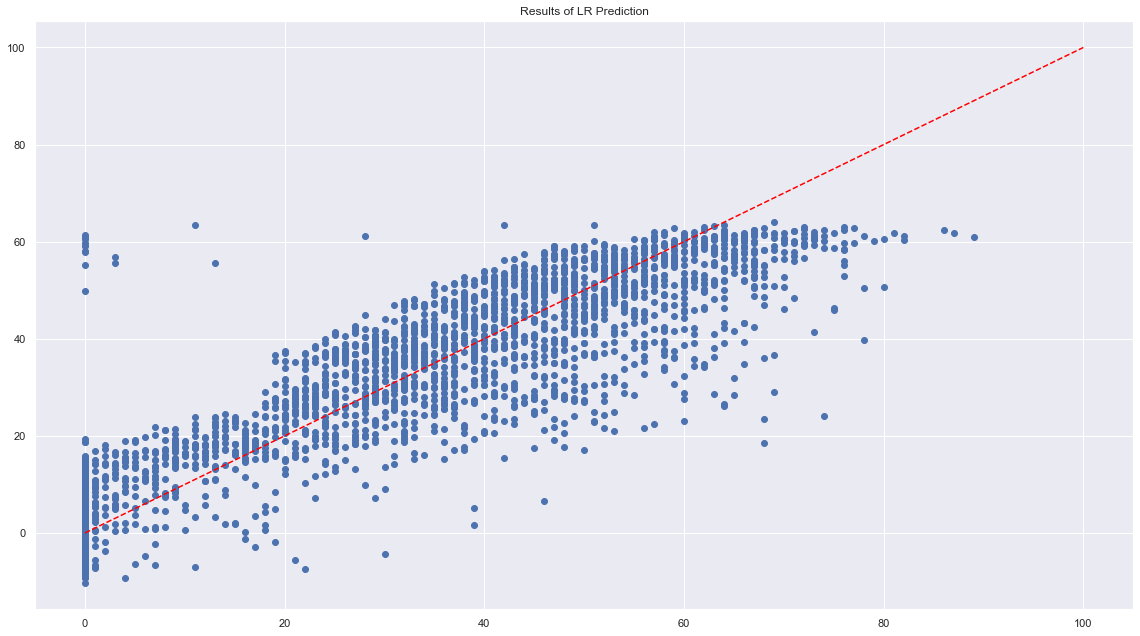

In [63]:
LR_Model = LinearRegression()
LR_Model.fit(X_train, y_train_reg)
LR_Predict = LR_Model.predict(X_test)

plot_results(reg_metrics, y_test_reg, y_test_class, LR_Predict, "LR")

### Random Forest

Mean Squared Error 99.771
R2 Score 0.79
Explained Variance Score 0.79

Converting regression to classification...
Accuracy score: 0.72
Saving figure results_of_RF_prediction


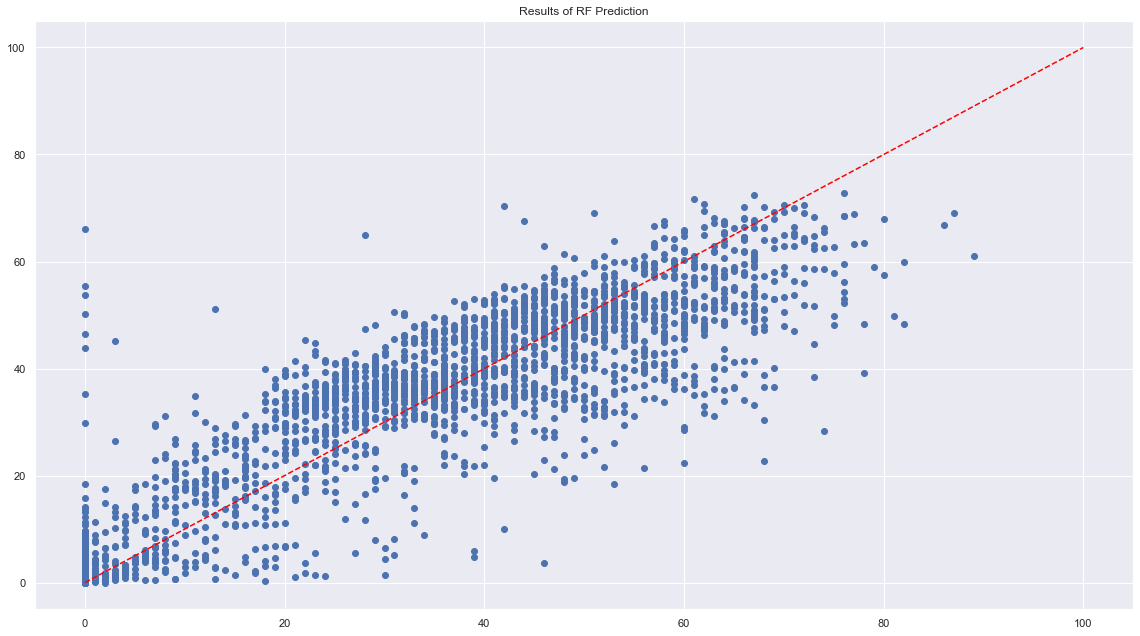

In [64]:
RF_Model = RandomForestRegressor()
RF_Model.fit(X_train, y_train_reg)
RF_Predict = RF_Model.predict(X_test)

plot_results(reg_metrics, y_test_reg, y_test_class, RF_Predict, "RF")

In [65]:
feature_df_rf = pd.DataFrame({
    'Importance': RF_Model.feature_importances_,
    'Features': features
})

feature_df_rf

Importance          Features
0     0.017912           valence
1     0.782313              year
2     0.019944      acousticness
3     0.020822            energy
4     0.019228  instrumentalness
5     0.010489               key
6     0.021263          liveness
7     0.021496          loudness
8     0.002011              mode
9     0.018995       speechiness
10    0.023699      log_duration
11    0.022808        tempo_norm
12    0.019020        dance_norm

### K-Nearest Neighbors

Mean Squared Error 119.354
R2 Score 0.749
Explained Variance Score 0.749

Converting regression to classification...
Accuracy score: 0.688
Saving figure results_of_KNN_prediction


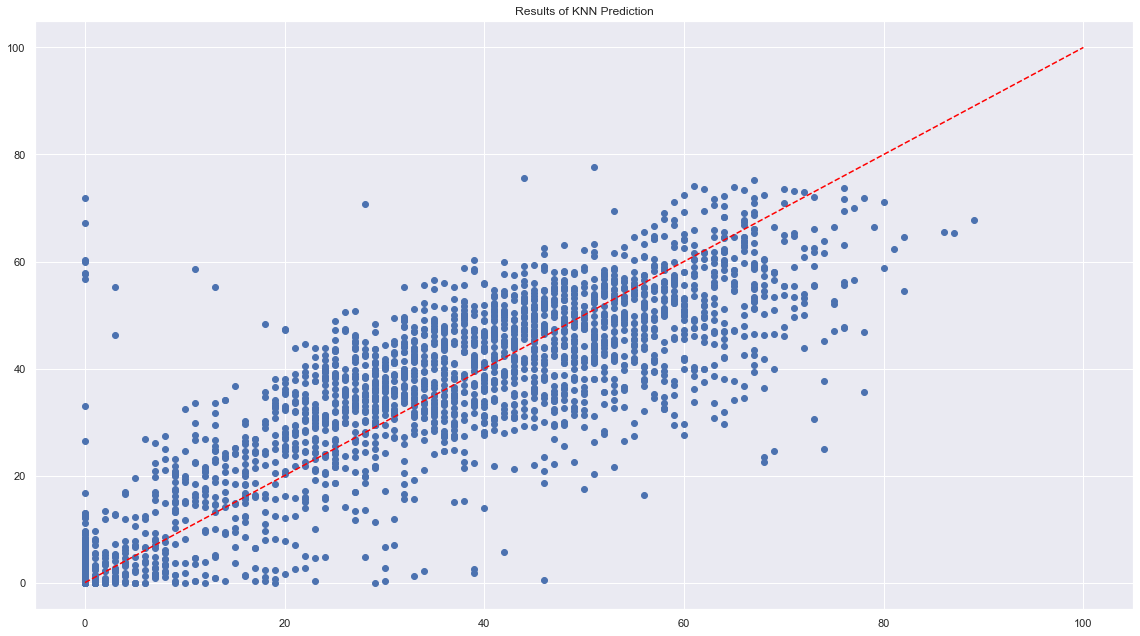

In [66]:
KNN_Model = KNeighborsRegressor()
KNN_Model.fit(X_train, y_train_reg)
KNN_Predict = KNN_Model.predict(X_test)

plot_results(reg_metrics, y_test_reg, y_test_class, KNN_Predict, "KNN")

### Decision Tree

Mean Squared Error 215.891
R2 Score 0.546
Explained Variance Score 0.546

Converting regression to classification...
Accuracy score: 0.6224
Saving figure results_of_DT_prediction


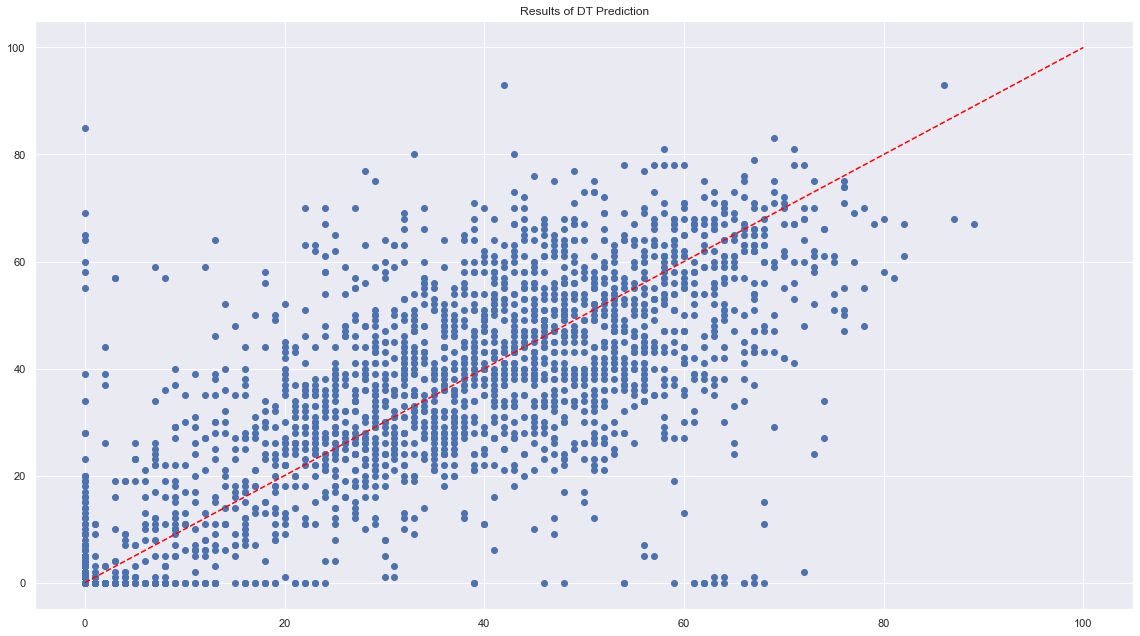

In [67]:
DT_Model = DecisionTreeRegressor()
DT_Model.fit(X_train, y_train_reg)
DT_Predict = DT_Model.predict(X_test)

plot_results(reg_metrics, y_test_reg, y_test_class, DT_Predict, "DT")

In [68]:
feature_df_dt = pd.DataFrame({
    'Importance': DT_Model.feature_importances_,
    'Features': features
})

feature_df_dt

Importance          Features
0     0.018657           valence
1     0.783637              year
2     0.017123      acousticness
3     0.020430            energy
4     0.018923  instrumentalness
5     0.009260               key
6     0.020055          liveness
7     0.019987          loudness
8     0.003015              mode
9     0.020654       speechiness
10    0.018545      log_duration
11    0.031354        tempo_norm
12    0.018361        dance_norm

### Linear SVR

Mean Squared Error 117.926
R2 Score 0.752
Explained Variance Score 0.757

Converting regression to classification...
Accuracy score: 0.6644
Saving figure results_of_LSVR_prediction


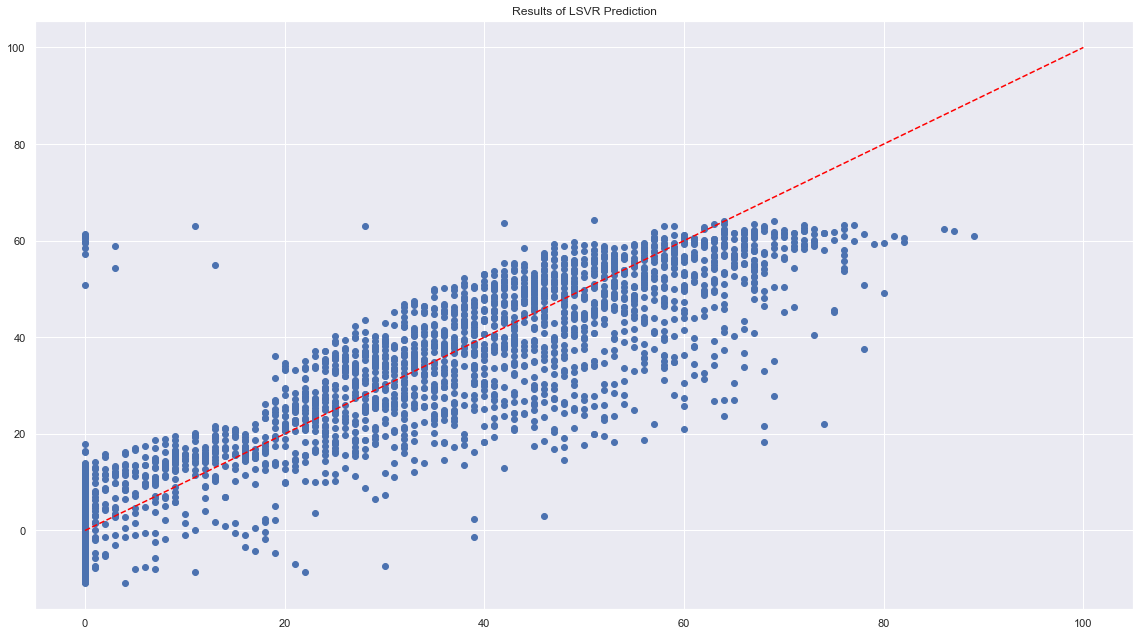

In [69]:
LSVR_Model = LinearSVR()
LSVR_Model.fit(X_train_scaled, y_train_reg)
LSVR_Predict = LSVR_Model.predict(X_test_scaled)

plot_results(reg_metrics, y_test_reg, y_test_class, LSVR_Predict, "LSVR")

In [70]:
feature_df_lsvr = pd.DataFrame({
    'Coefficients': LSVR_Model.coef_,
    'Features': features
})

feature_df_lsvr

Coefficients          Features
0      -0.226039           valence
1      17.901928              year
2      -1.195273      acousticness
3      -0.110774            energy
4      -0.867343  instrumentalness
5      -0.148519               key
6      -0.500241          liveness
7       0.009088          loudness
8      -0.327831              mode
9      -0.726379       speechiness
10      0.599405      log_duration
11      0.141837        tempo_norm
12      1.027037        dance_norm

### SVR

Mean Squared Error 122.988
R2 Score 0.742
Explained Variance Score 0.747

Converting regression to classification...
Accuracy score: 0.6604
Saving figure results_of_SVR_prediction


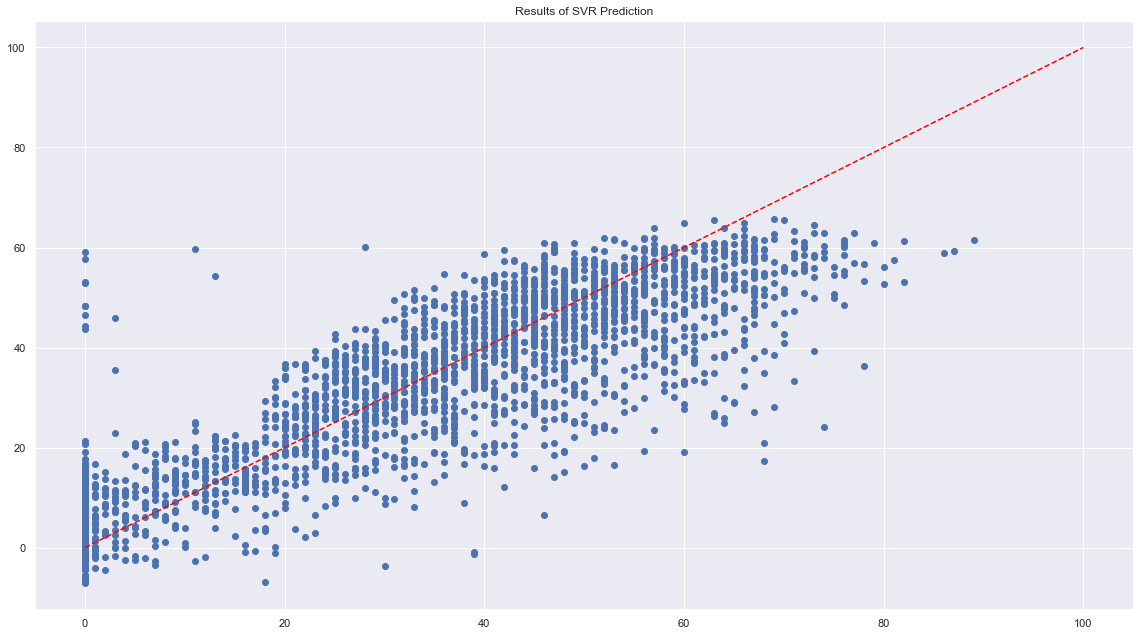

In [71]:
SVR_Model = SVR()
SVR_Model.fit(X_train_scaled, y_train_reg)
SVR_Predict = SVR_Model.predict(X_test_scaled)

plot_results(reg_metrics, y_test_reg, y_test_class, SVR_Predict, "SVR")

### Réseaux de neuronnes

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_A):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_A[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_A[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [ ]:
from sklearn.base import BaseEstimator


class NeverAClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_A_clf = NeverAClassifier()
cross_val_score(never_A_clf, X_train, y_train_A, cv=3, scoring='accuracy')

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_A, cv=3)

In [ ]:
confusion_matrix(y_train_A, y_train_pred)

In [ ]:
y_train_perfect_predictions = y_train_A
confusion_matrix(y_train_A, y_train_perfect_predictions)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_A, y_train_pred)

In [ ]:
cm = confusion_matrix(y_train_A, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

In [ ]:
recall_score(y_train_A, y_train_pred)

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [ ]:
plt.figure(figsize=(15, 15))
plt.matshow(cm)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_A, y_train_pred)

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

In [ ]:
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_A,
                             cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_A, y_scores)

In [ ]:
recall_90_precision = recalls[np.argmax(precisions >= 0.20)]
print(recall_90_precision)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,
             precisions[:-1],
             "b--",
             label="Precision",
             linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_20_precision = recalls[np.argmax(precisions >= 0.20)]
threshold_20_precision = thresholds[np.argmax(precisions >= 0.20)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_20_precision, threshold_20_precision], [0., 0.2], "r:")
plt.plot([-50000, threshold_20_precision], [0.2, 0.2], "r:")
plt.plot([-50000, threshold_20_precision],
         [recall_20_precision, recall_20_precision], "r:")
plt.plot([threshold_20_precision], [0.2], "ro")
plt.plot([threshold_20_precision], [recall_20_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, .6])
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_20_precision, recall_20_precision], [0., 0.2], "r:")
plt.plot([0.0, recall_20_precision], [0.2, 0.2], "r:")
plt.plot([recall_20_precision], [0.2], "ro")
save_fig("precision_vs_recall_plot")
plt.show()